In [ ]:
# ==============================================================================
# DATE: 10-01-2026
# PROJECT: Forecasting the Unemployment Rate in Italy
# MODEL: ARIMA/SARIMA/RNN/LSTM 
# GENERAL DESCRIPTION:

# This script performs an analysis and forecasting of the unemployment rate in Italy,
# disaggregated by gender and age group, using classical models, recurrent
# neural networks

# 1. DATA LOADING AND PREPROCESSING
# - Time series are loaded, missing values are handled, and the data is normalized.
# - Differencing is applied when necessary to achieve stationarity.

# 2. EXPLORATORY ANALYSIS AND VISUALIZATION
# - Seasonal patterns are observed, with noticeable peaks in the third quarter of the year.
# - Significant differences are identified between genders and age groups.

# 3. CLASSICAL MODELING (ARIMA and SARIMA)
# - Parameters p, d, q and seasonal P, D, Q, s are identified using ACF, PACF, AIC, and BIC.
# - The performance of individual models is evaluated by group and gender.

# 4. NEURAL NETWORK DESIGN (RNN, LSTM, GRU)
# - Networks use the 'tanh' activation function in hidden layers and 'ReLU' in the output layer.
# - Hyperparameters such as number of epochs, window size, batch size, and dropout are configured.
# - The NADAM optimizer is used to improve convergence.


#Import the file to read it

import pandas as pd
import matplotlib.pyplot as plt
disocupati_trimestral = pd.read_csv('C:/Users/2davi/OneDrive/Desktop/Trabajo/Tesis/Tesis/Disocupati_II.csv', 
                       index_col='Period', 
                       parse_dates=True)
print(disocupati_trimestral)

             15-34 M    15-34 F   35-49 M   35-49 F   50-74 M   50-74 F  \
Period                                                                    
2004-Q1    11.720628  17.198032  4.283283  8.776062  4.004764  5.376203   
2004-Q2    11.410664  16.187372  3.654493  7.196378  3.636536  4.515018   
2004-Q3    10.041510  15.682014  3.520125  6.945425  3.394804  3.976243   
2004-Q4    11.918557  17.227696  4.020448  7.582207  3.604743  3.583677   
2005-Q1    12.334781  16.852636  4.316241  7.577546  3.440298  4.204936   
...              ...        ...       ...       ...       ...       ...   
2024-Q1    12.365911  14.369536  5.682832  8.537508  4.504719  5.837779   
2024-Q2    10.868221  13.000800  4.814713  7.091986  4.057952  4.814553   
2024-Q3    10.391842  10.590439  4.218075  5.802678  3.030988  3.656154   
2024-Q4    10.925559  12.400330  4.410602  6.221986  3.202396  4.001726   
2025-Q1    11.640231  13.868486  4.948448  7.037018  4.070563  4.589607   

           Global_Rate  

QUARTERLY TIME CHART GLOBAL UNEMPLOYMENT RATE


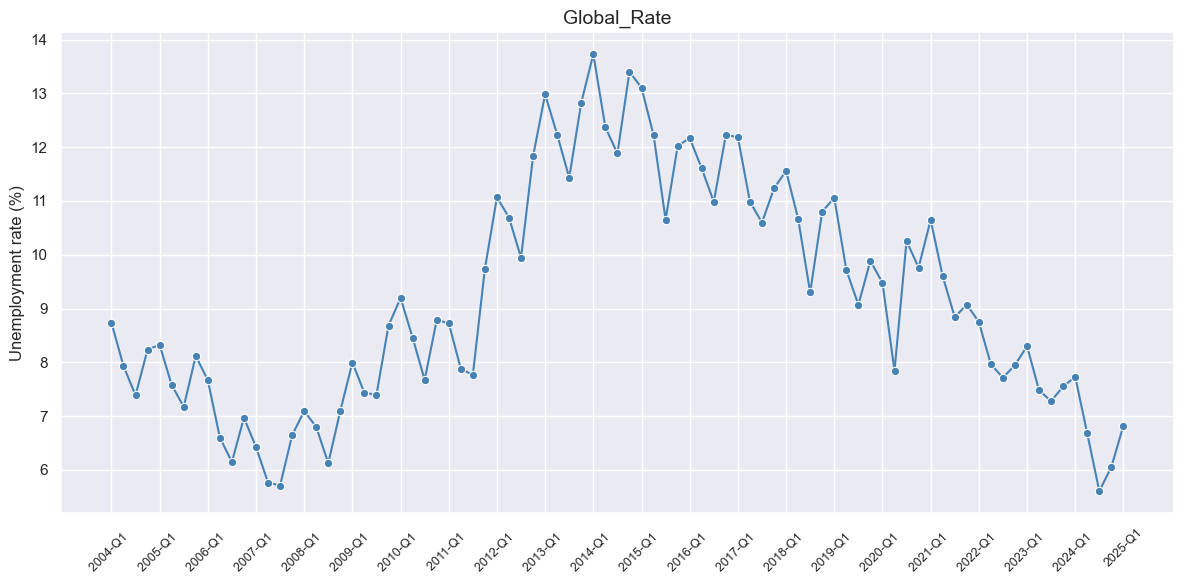

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

colonna = 'Global_Rate'
posizioni_tick = disocupati_trimestral.index[::4]

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=disocupati_trimestral.index,
    y=disocupati_trimestral[colonna],
    color='steelblue',
    marker='o'  
) 

plt.title(colonna, fontsize=14)
plt.ylabel('Unemployment rate (%)')
plt.xticks(ticks=posizioni_tick, labels=posizioni_tick, rotation=45, fontsize=9)
plt.xlabel('') 
plt.grid(True)
plt.tight_layout()
plt.show()

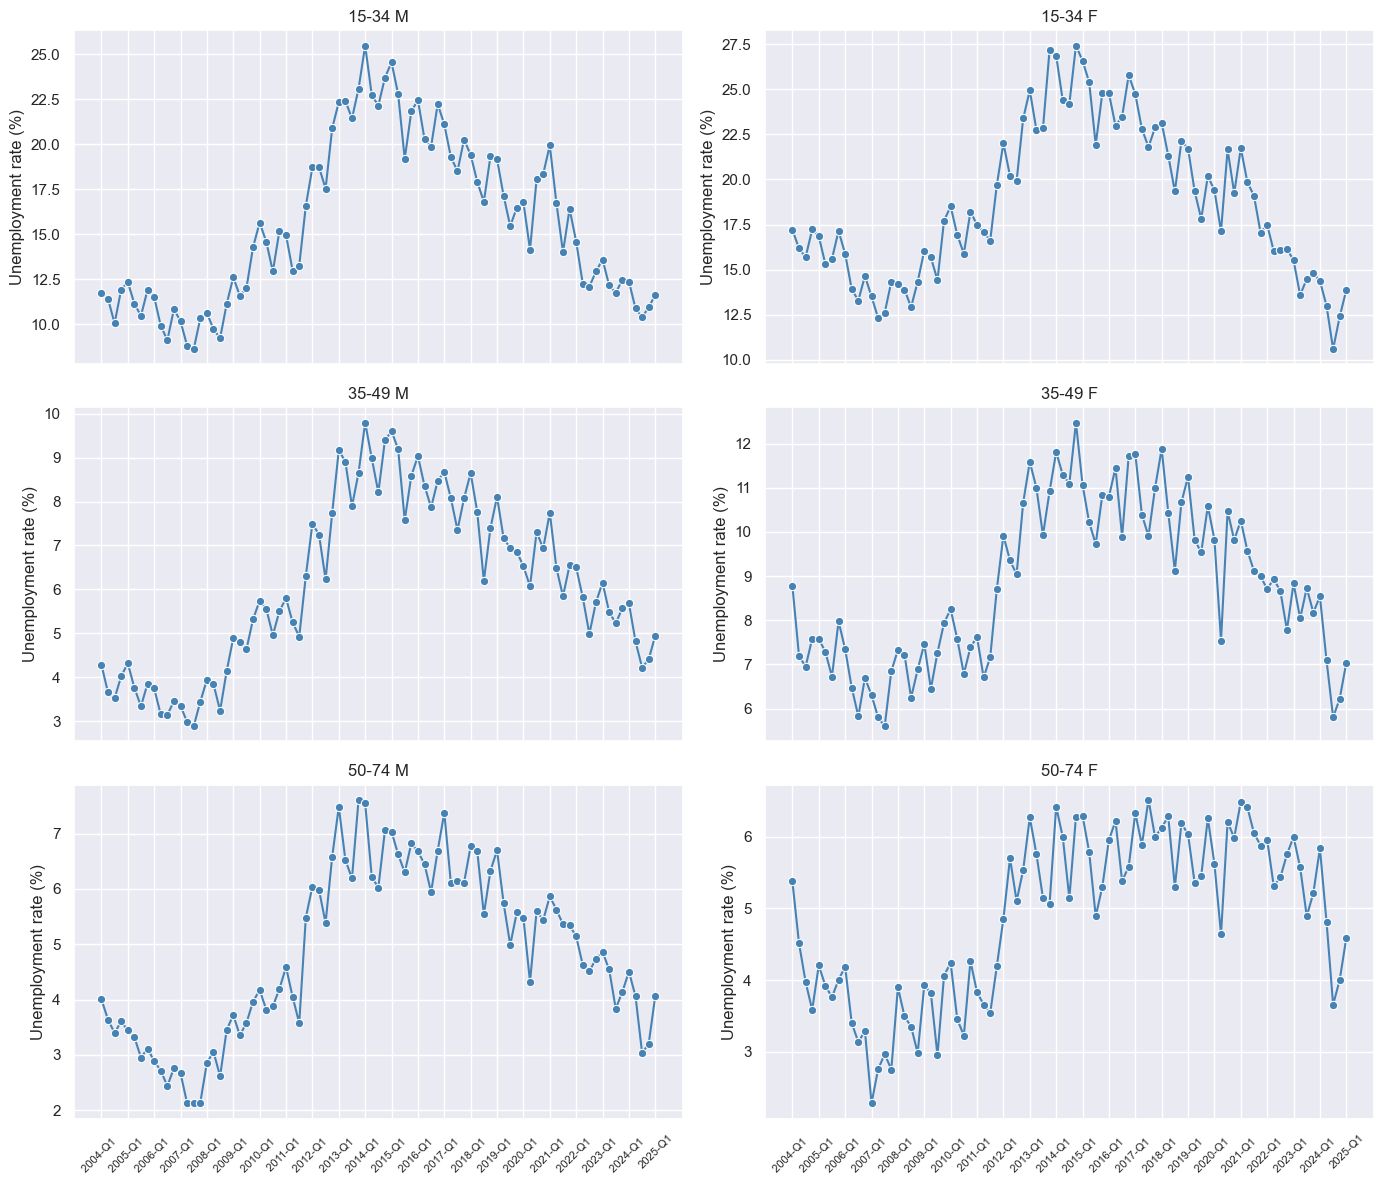

In [336]:


sns.set_theme(style="darkgrid")

colonne_da_grafico = disocupati_trimestral.columns[:6]
posizioni_tick = disocupati_trimestral.index[::4]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=True)

for i, col in enumerate(colonne_da_grafico):
    ax = axes[i // 2, i % 2]
    sns.lineplot(
        ax=ax, 
        x=disocupati_trimestral.index, 
        y=disocupati_trimestral[col], 
        color='steelblue', 
        marker='o' 
    )
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Unemployment rate (%)')
    ax.set_xticks(posizioni_tick)
    ax.set_xticklabels(posizioni_tick, rotation=45, fontsize=8)
    ax.grid(True)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()




In [337]:
import numpy as np
from scipy import stats

# Create an empty DataFrame to store the results
summary_stats = pd.DataFrame(columns=[
    'nobs', 'nans', 'min', 'max', 'Q1', 'Q3', 'mean', 'median', 'sum', 'SE_mean',
    'LCL_mean', 'UCL_mean', 'variance', 'stdev', 'skewness', 'kurtosis'
])

# Confidence Level
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

for col in disocupati_trimestral.columns:
    Y = disocupati_trimestral[col].dropna()
    nobs = len(Y)
    nans = disocupati_trimestral[col].isna().sum()
    minimum = Y.min()
    maximum = Y.max()
    Q1 = Y.quantile(0.25)
    Q3 = Y.quantile(0.75)
    mean = Y.mean()
    median = Y.median()
    sum_values = Y.sum()
    se_mean = stats.sem(Y)
    margin_of_error = z_score * se_mean
    lcl_mean = mean - margin_of_error
    ucl_mean = mean + margin_of_error
    variance = Y.var()
    stdev = Y.std()
    skewness = stats.skew(Y)
    kurtosis = stats.kurtosis(Y)

    # Add row to summary DataFrame
    summary_stats.loc[col] = [
        nobs, nans, minimum, maximum, Q1, Q3, mean, median, sum_values,
        se_mean, lcl_mean, ucl_mean, variance, stdev, skewness, kurtosis
    ]


summary_stats = summary_stats.round(2)
summary_stats_transposed = summary_stats.T
print(summary_stats_transposed)



          15-34 M  15-34 F  35-49 M  35-49 F  50-74 M  50-74 F  Global_Rate
nobs        85.00    85.00    85.00    85.00    85.00    85.00        85.00
nans         0.00     0.00     0.00     0.00     0.00     0.00         0.00
min          8.61    10.59     2.88     5.60     2.12     2.28         5.60
max         25.49    27.43     9.80    12.47     7.61     6.52        13.73
Q1          11.72    15.52     4.41     7.26     3.58     3.92         7.55
Q3          19.28    22.01     7.75    10.39     6.11     5.96        10.98
mean        15.56    18.63     6.10     8.79     4.84     4.89         9.18
median      14.59    17.49     5.84     8.73     4.74     5.14         8.75
sum       1322.93  1583.89   518.42   747.16   411.16   415.74       780.07
SE_mean      0.49     0.46     0.21     0.20     0.16     0.12         0.23
LCL_mean    14.60    17.74     5.69     8.41     4.52     4.65         8.73
UCL_mean    16.53    19.53     6.51     9.18     5.16     5.14         9.63
variance    

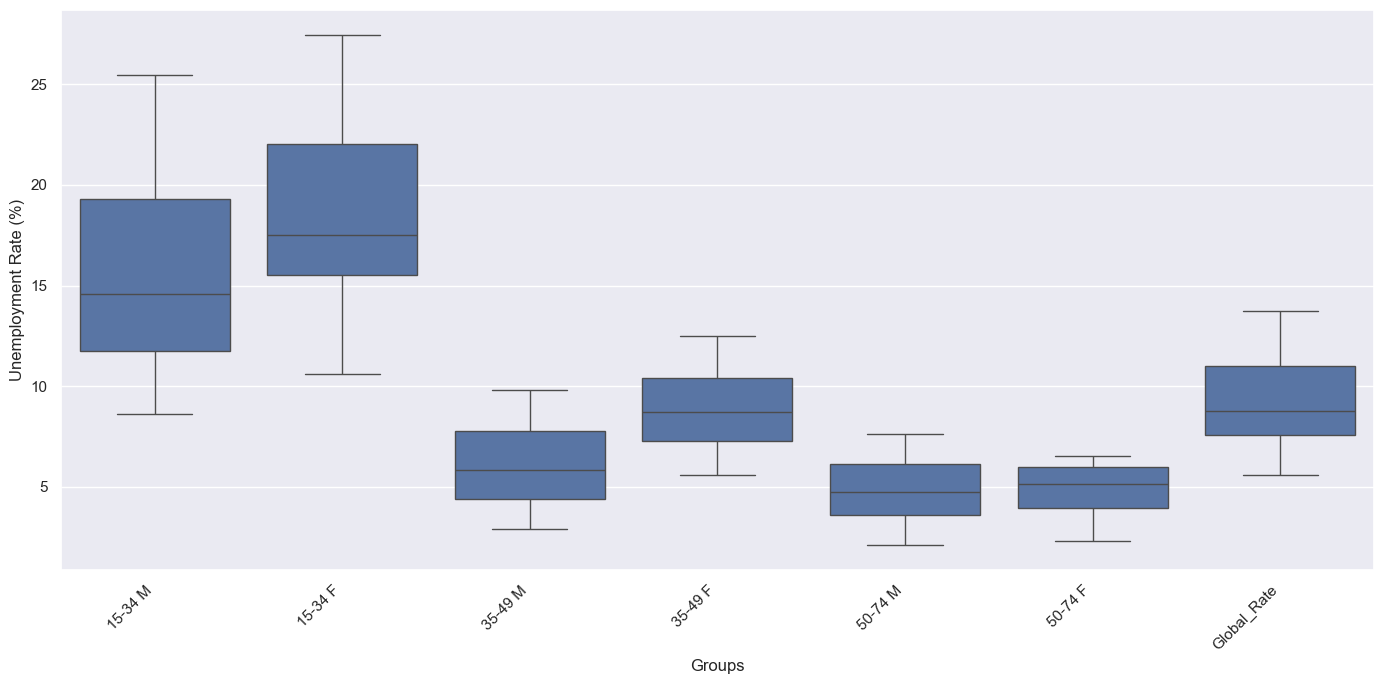

In [338]:
# Boxplots of Unemployment Rate by Age and Gender Groups in Italy
df_melted = disocupati_trimestral.reset_index().melt(id_vars='Period', var_name='Group', value_name='Unemployment Rate')

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_melted, x='Group', y='Unemployment Rate')
#plt.title('Boxplots of Unemployment Rate by Age and Gender Groups in Italy')
plt.xlabel('Groups')
plt.ylabel('Unemployment Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


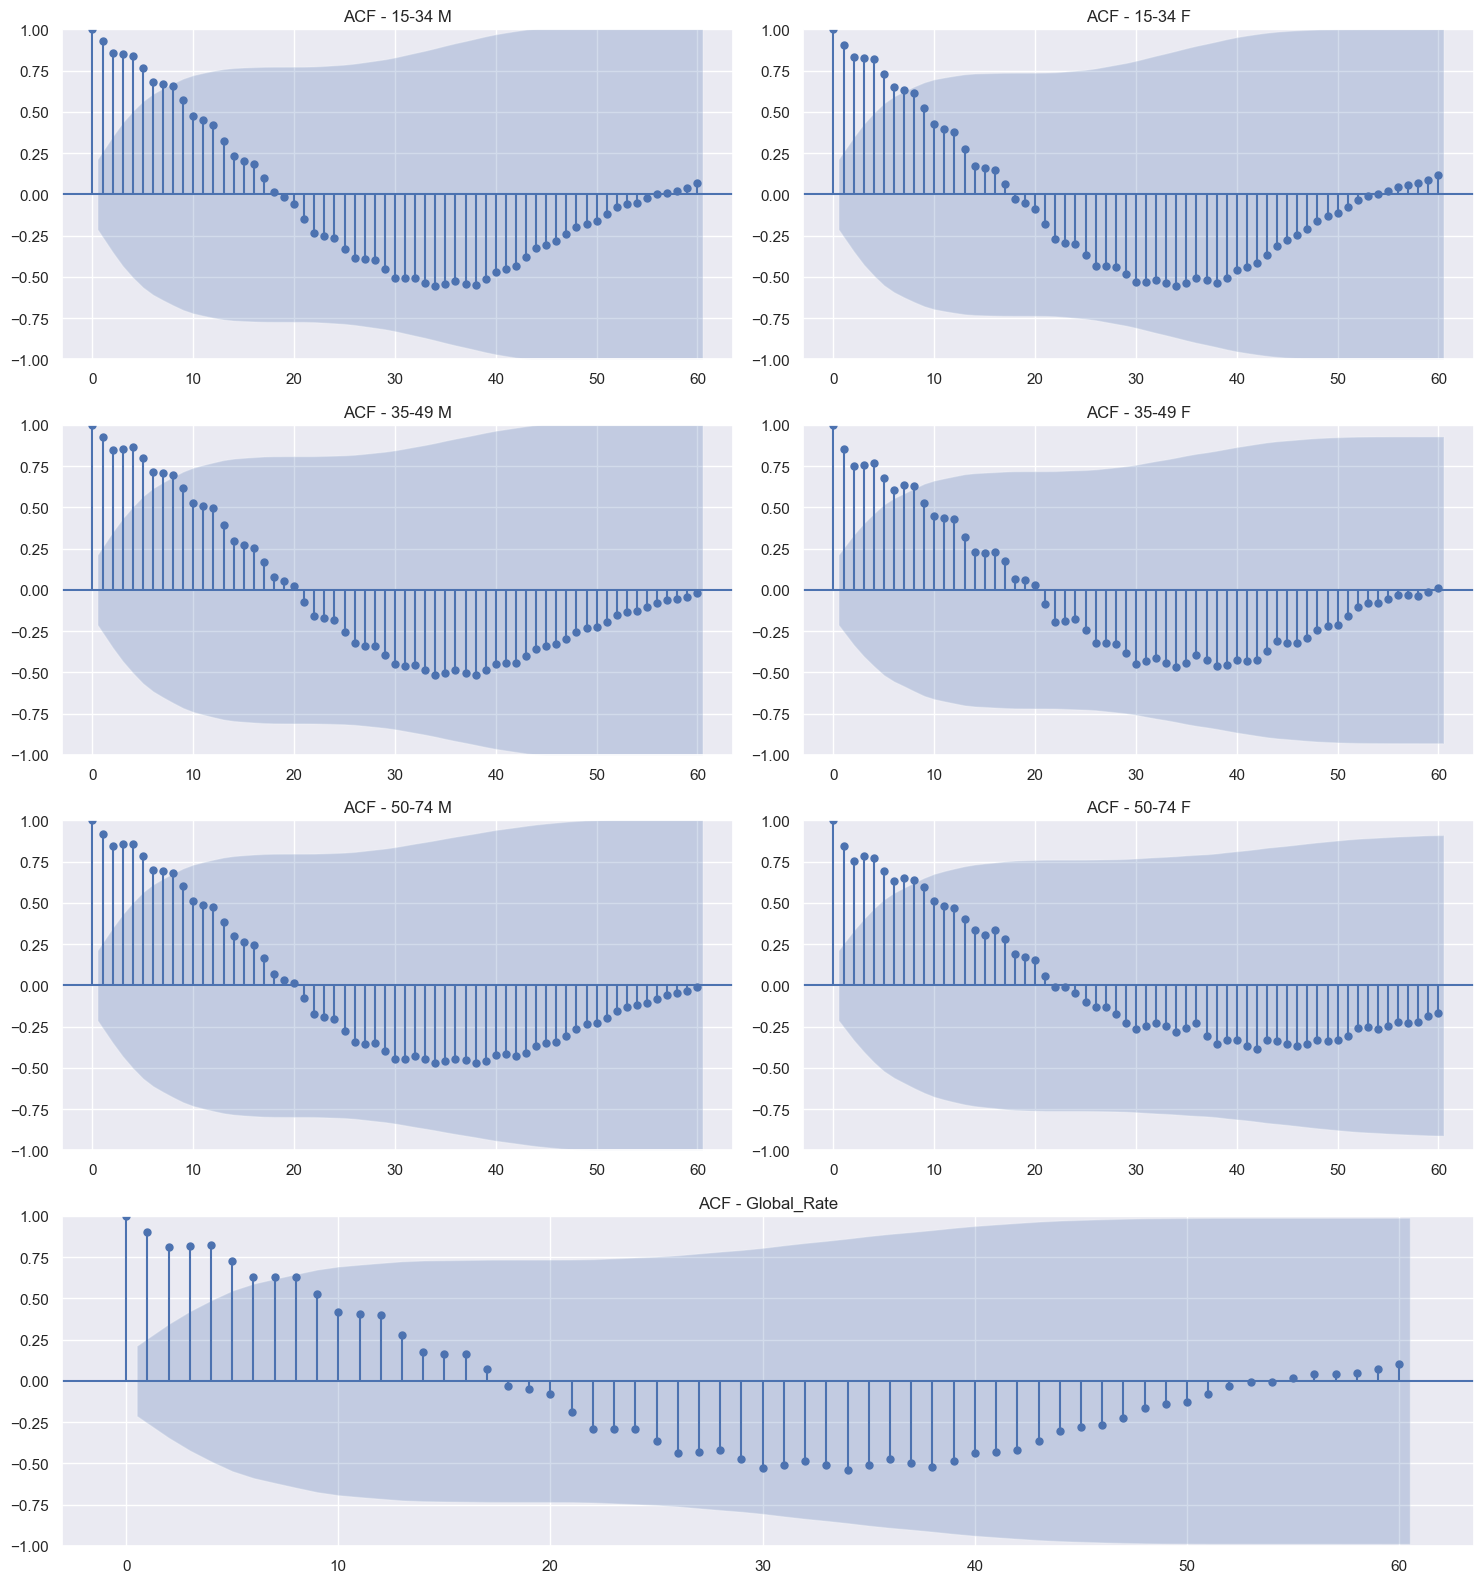

In [339]:
from statsmodels.graphics.tsaplots import plot_acf

# Number of rites to be considered
lags = 60

# Lista delle colonne
colonne = disocupati_trimestral.columns.tolist()
n_colonne = 2
n_totale = len(colonne)
n_righe = (n_totale + 1) // n_colonne  

plt.figure(figsize=(15, 4 * n_righe))

for i, colonna in enumerate(colonne):
    if (i == n_totale - 1) and (n_totale % 2 != 0):
        plt.subplot(n_righe, 1, n_righe)  
    else:
        plt.subplot(n_righe, n_colonne, i + 1)
    
    plot_acf(disocupati_trimestral[colonna], lags=lags, ax=plt.gca(), title=f'ACF - {colonna}')

plt.tight_layout()
plt.show()

In [340]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox

colonne = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]

# Number of delays to consider for the Box-Ljung test
ritardi = 20

# List of results
risultati = []

for colonna in colonne:
    serie = disocupati_trimestral[colonna]
    # Test ADF
    adf_result = adfuller(serie)
    adf_stat = adf_result[0]
    adf_pvalue = adf_result[1]

    # Test Phillips-Perron
    pp_test = PhillipsPerron(serie)
    pp_stat = pp_test.stat
    pp_pvalue = pp_test.pvalue

    # Test KPSS
    kpss_stat, kpss_pvalue, _, _ = kpss(serie, regression='c', nlags='auto')

    # Test Box-Ljung
    box_test = acorr_ljungbox(serie, lags=[ritardi], return_df=True)
    lb_pvalue = box_test['lb_pvalue'].values[0]

    # Safe results
    risultati.append({
        "Serie": colonna,
        "Statistica ADF": adf_stat,
        "p-valore ADF": adf_pvalue,
        "Statistica PP": pp_stat,
        "p-valore PP": pp_pvalue,
        "Statistica KPSS": kpss_stat,
        "p-valore KPSS": kpss_pvalue,
        f"p-valore Ljung-Box (lag {ritardi})": lb_pvalue
    })


risultati_df = pd.DataFrame(risultati)
risultati_df

Serie  Statistica ADF  p-valore ADF  Statistica PP  p-valore PP  \
0      15-34 M       -1.702559      0.429795      -1.639356     0.462598   
1      15-34 F       -1.878017      0.342472      -1.768276     0.396322   
2      35-49 M       -2.355920      0.154566      -1.674613     0.444238   
3      35-49 F       -1.100774      0.714763      -2.466856     0.123748   
4      50-74 M       -1.630510      0.467224      -1.774752     0.393067   
5      50-74 F       -1.238017      0.657032      -2.757766     0.064564   
6  Global_Rate       -2.127660      0.233539      -1.815051     0.373015   

   Statistica KPSS  p-valore KPSS  p-valore Ljung-Box (lag 20)  
0         0.450485       0.055394                7.083708e-108  
1         0.365544       0.092007                 7.547877e-96  
2         0.617958       0.021004                3.460150e-121  
3         0.555858       0.029086                 8.426795e-91  
4         0.608630       0.021852                7.421381e-117  
5         0.921625       0.010000                1.629345e-105  
6         0.385045       0.083601                 3.541922e-95

First Difference

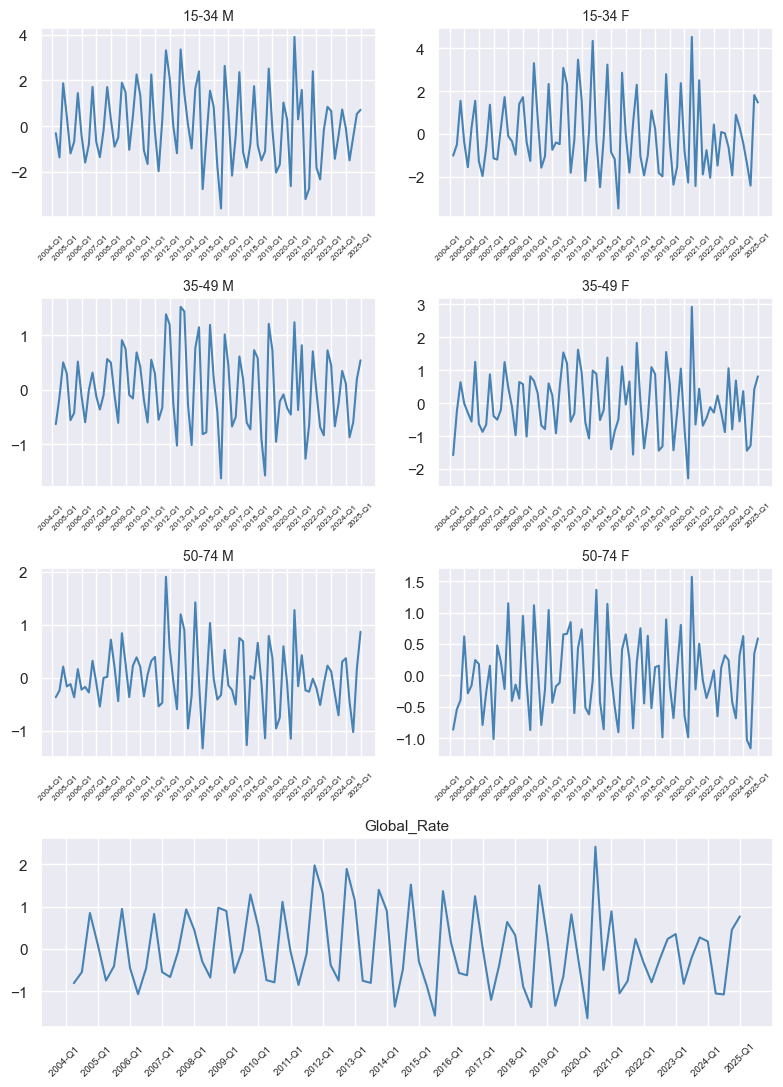

In [341]:
# Apply first-order differentiation to all columns
diff_df = disocupati_trimestral.diff()
#diff_df = diff_df.dropna()

# Tick positions on the x-axis every 4 quarters
tick_positions = disocupati_trimestral.index[::4]

# List of columns
columns = disocupati_trimestral.columns

# Create the figure: 3 rows, 2 columns + 1 row for the wide graph
fig = plt.figure(figsize=(8, 12))

# Add the first 6 subcharts (3 rows x 2 columns)
for i in range(6):
    ax = plt.subplot(4, 2, i + 1)
    ax.plot(diff_df[columns[i]], label=f'{columns[i]} (Differenza)', color='steelblue')
    ax.set_title(columns[i], fontsize=10)
    ax.set_xticks(tick_positions)
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    #ax.legend(fontsize=6)

# Add the seventh full-width chart
ax7 = plt.subplot2grid((4, 2), (3, 0), colspan=2)
ax7.plot(diff_df[columns[6]], label=f'{columns[6]} (Differenza)', color='steelblue')
ax7.set_title(columns[6], fontsize=11)
ax7.set_xticks(tick_positions)
ax7.tick_params(axis='x', rotation=45, labelsize=7)
#ax7.legend(fontsize=7)

#fig.suptitle('First differentiation of the quarterly series of the unemployment rate by age and gender', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [342]:
diff_df

15-34 M   15-34 F   35-49 M   35-49 F   50-74 M   50-74 F  \
Period                                                                  
2004-Q1         NaN       NaN       NaN       NaN       NaN       NaN   
2004-Q2   -0.309964 -1.010660 -0.628790 -1.579684 -0.368228 -0.861185   
2004-Q3   -1.369154 -0.505358 -0.134368 -0.250953 -0.241732 -0.538775   
2004-Q4    1.877047  1.545682  0.500323  0.636782  0.209939 -0.392566   
2005-Q1    0.416224 -0.375060  0.295793 -0.004661 -0.164445  0.621259   
...             ...       ...       ...       ...       ...       ...   
2024-Q1   -0.097266 -0.425090  0.112614  0.363830  0.369091  0.624647   
2024-Q2   -1.497690 -1.368736 -0.868119 -1.445522 -0.446767 -1.023226   
2024-Q3   -0.476379 -2.410361 -0.596638 -1.289308 -1.026964 -1.158399   
2024-Q4    0.533717  1.809891  0.192527  0.419308  0.171408  0.345572   
2025-Q1    0.714672  1.468156  0.537846  0.815032  0.868167  0.587881   

           Global_Rate  
Period                  
2004-Q1            NaN  
2004-Q2      -0.807280  
2004-Q3      -0.544585  
2004-Q4       0.849237  
2005-Q1       0.088782  
...                ...  
2024-Q1       0.178579  
2024-Q2      -1.052249  
2024-Q3      -1.073498  
2024-Q4       0.449843  
2025-Q1       0.768427  

[85 rows x 7 columns]

In [343]:
import warnings
warnings.filterwarnings('ignore')
diff_df =diff_df.dropna()


colonne = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]

# Number of delays to consider for the Box-Ljung test
ritardi = 20

# List to save results
risultati = []

for colonna in colonne:
    #print(f"\n==== Analisi della serie: {colonna} ====")
    #serie = disocupati_trimestral[colonna].dropna()  # Removes any NaN values
    serie = diff_df[colonna]
    # Test ADF
    adf_result = adfuller(serie)
    adf_stat = adf_result[0]
    adf_pvalue = adf_result[1]

    # Test Phillips-Perron
    pp_test = PhillipsPerron(serie)
    pp_stat = pp_test.stat
    pp_pvalue = pp_test.pvalue

    # Test KPSS
    kpss_stat, kpss_pvalue, _, _ = kpss(serie, regression='c', nlags='auto')

    # Test Box-Ljung
    box_test = acorr_ljungbox(serie, lags=[ritardi], return_df=True)
    lb_pvalue = box_test['lb_pvalue'].values[0]

    # Saving the results
    risultati.append({
        "Serie": colonna,
        "Statistica ADF": adf_stat,
        "p-valore ADF": adf_pvalue,
        "Statistica PP": pp_stat,
        "p-valore PP": pp_pvalue,
        "Statistica KPSS": kpss_stat,
        "p-valore KPSS": kpss_pvalue,
        f"p-valore Ljung-Box (lag {ritardi})": lb_pvalue
    })

# Creating a DataFrame with the results
risultati_df = pd.DataFrame(risultati)
risultati_df

Serie  Statistica ADF  p-valore ADF  Statistica PP   p-valore PP  \
0      15-34 M       -2.064160  2.591680e-01      -9.623905  1.680476e-16   
1      15-34 F       -1.705545  4.282579e-01     -10.857319  1.476317e-19   
2      35-49 M       -1.299612  6.293498e-01      -9.730652  9.023501e-17   
3      35-49 F       -4.592053  1.335971e-04     -12.551717  2.198529e-23   
4      50-74 M       -2.509052  1.132873e-01     -10.390560  2.026183e-18   
5      50-74 F      -11.480108  5.018665e-21     -13.089500  1.800731e-24   
6  Global_Rate       -1.673597  4.447647e-01     -10.060077  1.340752e-17   

   Statistica KPSS  p-valore KPSS  p-valore Ljung-Box (lag 20)  
0         0.228299            0.1                 7.352819e-50  
1         0.187168            0.1                 2.007577e-30  
2         0.223511            0.1                 1.331789e-57  
3         0.170902            0.1                 1.043610e-16  
4         0.165149            0.1                 7.300501e-32  
5         0.144185            0.1                 1.056070e-06  
6         0.170972            0.1                 6.756196e-54

PCF and PACF

In [344]:
diff_df

15-34 M   15-34 F   35-49 M   35-49 F   50-74 M   50-74 F  \
Period                                                                  
2004-Q2   -0.309964 -1.010660 -0.628790 -1.579684 -0.368228 -0.861185   
2004-Q3   -1.369154 -0.505358 -0.134368 -0.250953 -0.241732 -0.538775   
2004-Q4    1.877047  1.545682  0.500323  0.636782  0.209939 -0.392566   
2005-Q1    0.416224 -0.375060  0.295793 -0.004661 -0.164445  0.621259   
2005-Q2   -1.195406 -1.548105 -0.556857 -0.295882 -0.120560 -0.283855   
...             ...       ...       ...       ...       ...       ...   
2024-Q1   -0.097266 -0.425090  0.112614  0.363830  0.369091  0.624647   
2024-Q2   -1.497690 -1.368736 -0.868119 -1.445522 -0.446767 -1.023226   
2024-Q3   -0.476379 -2.410361 -0.596638 -1.289308 -1.026964 -1.158399   
2024-Q4    0.533717  1.809891  0.192527  0.419308  0.171408  0.345572   
2025-Q1    0.714672  1.468156  0.537846  0.815032  0.868167  0.587881   

           Global_Rate  
Period                  
2004-Q2      -0.807280  
2004-Q3      -0.544585  
2004-Q4       0.849237  
2005-Q1       0.088782  
2005-Q2      -0.746270  
...                ...  
2024-Q1       0.178579  
2024-Q2      -1.052249  
2024-Q3      -1.073498  
2024-Q4       0.449843  
2025-Q1       0.768427  

[84 rows x 7 columns]

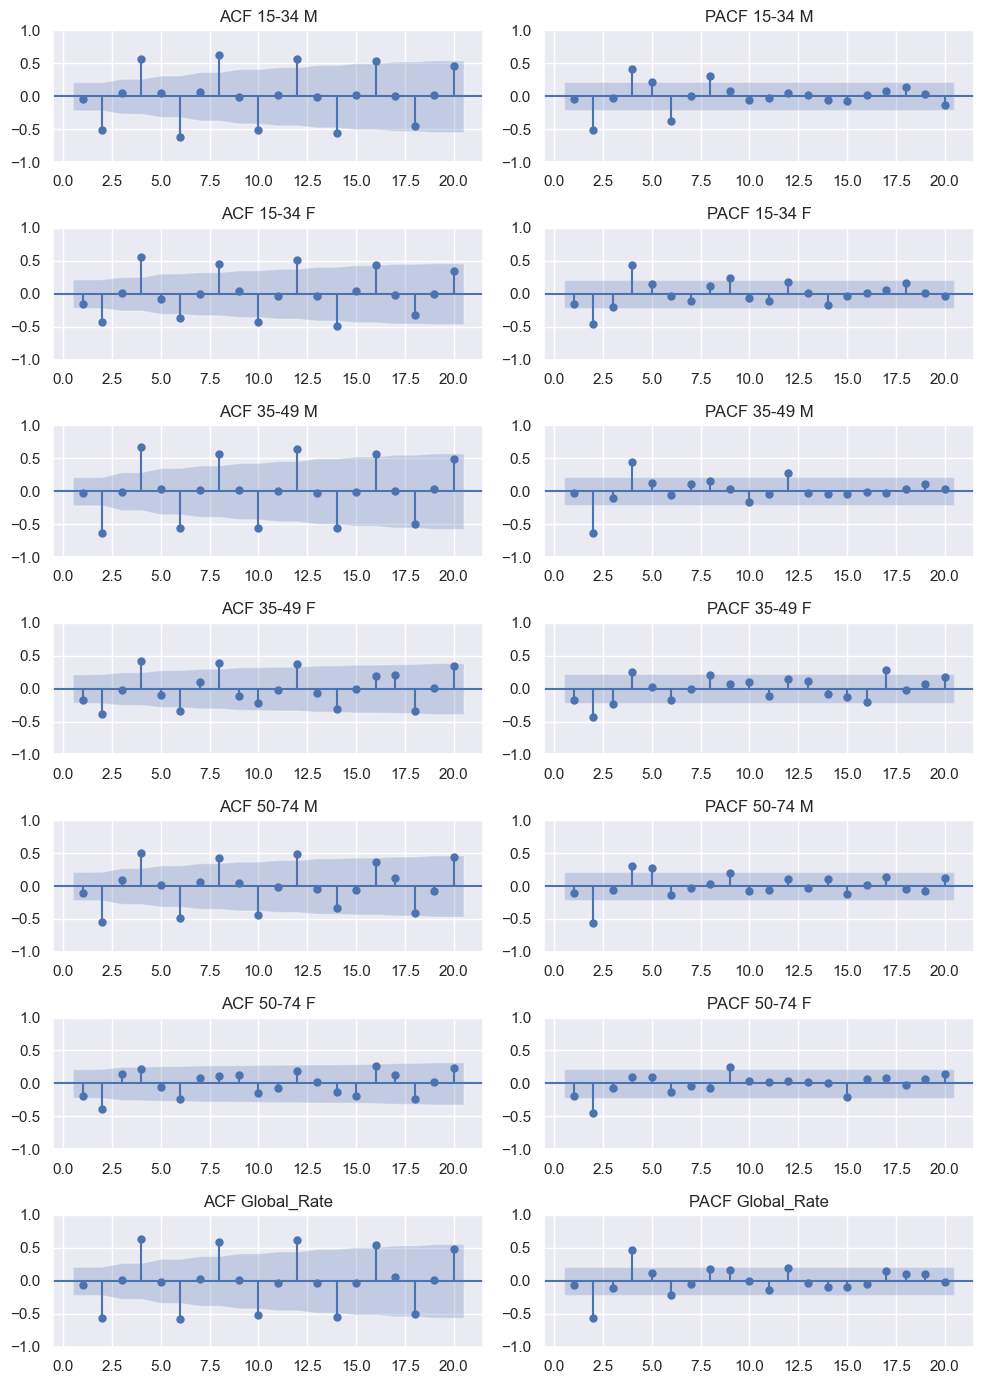

In [345]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
#diff_df = diff_df.dropna()
num_vars = len(diff_df.columns)
fig, axes = plt.subplots(num_vars, 2, figsize=(10, 2 * num_vars))  # 2 columns (ACF and PACF), 1 row per variable

for i, column in enumerate(diff_df.columns):
    X = diff_df[column].dropna()

    # ACF
    plot_acf(X, lags=20, ax=axes[i, 0], zero=False)
    axes[i, 0].set_title(f'ACF {column}')

    # PACF
    plot_pacf(X, lags=20, ax=axes[i, 1], zero=False)
    axes[i, 1].set_title(f'PACF {column}')

plt.tight_layout()
plt.show()

Second Difference

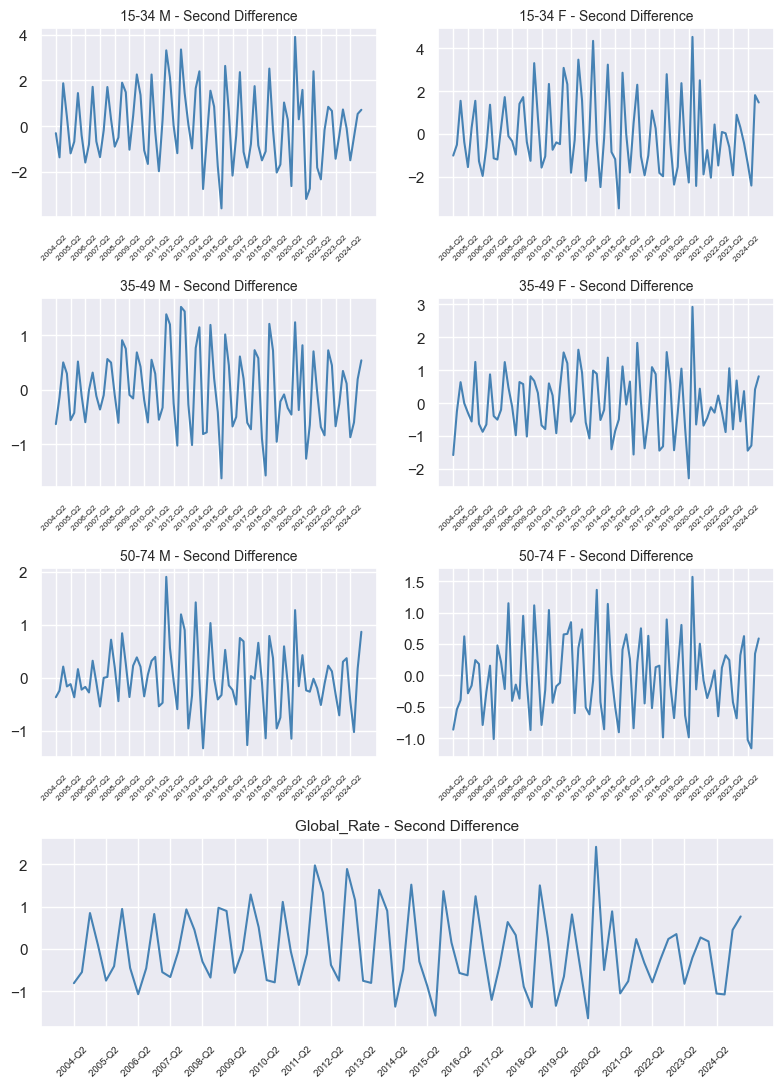

In [346]:
# Apply the differenziazione del primo ordine to all the colonne
diff_df2 = diff_df.diff()
#diff_df2 = diff_df2.dropna()

# Tick positions on the x-axis every 4 quarters
tick_positions = diff_df2.index[::4]

# List of columns
columns = diff_df2.columns

# Create the figure: 3 rows, 2 columns + 1 row for the wide graph
fig = plt.figure(figsize=(8, 12))

# Add the first 6 subcharts (3 rows x 2 columns)
for i in range(6):
    ax = plt.subplot(4, 2, i + 1)
    ax.plot(diff_df[columns[i]], label=f'{columns[i]} (Differenza)', color='steelblue')
    ax.set_title(f'{columns[i]} - Second Difference', fontsize=10)
    ax.set_xticks(tick_positions)
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    #ax.legend(fontsize=6)

# Add the seventh full-width chart
ax7 = plt.subplot2grid((4, 2), (3, 0), colspan=2)
ax7.plot(diff_df[columns[6]], label=f'{columns[6]} (Differenza)', color='steelblue')
ax7.set_title(f'{columns[6]} - Second Difference', fontsize=11)
ax7.set_xticks(tick_positions)
ax7.tick_params(axis='x', rotation=45, labelsize=7)
#ax7.legend(fontsize=7)

#fig.suptitle('Second differentiation of the quarterly series of the unemployment rate by age and gender', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [347]:
diff_df2

15-34 M   15-34 F   35-49 M   35-49 F   50-74 M   50-74 F  \
Period                                                                  
2004-Q2         NaN       NaN       NaN       NaN       NaN       NaN   
2004-Q3   -1.059190  0.505302  0.494422  1.328731  0.126496  0.322410   
2004-Q4    3.246201  2.051040  0.634691  0.887735  0.451671  0.146209   
2005-Q1   -1.460823 -1.920742 -0.204530 -0.641443 -0.374384  1.013825   
2005-Q2   -1.611630 -1.173045 -0.852650 -0.291221  0.043885 -0.905114   
...             ...       ...       ...       ...       ...       ...   
2024-Q1   -0.825152 -0.737038 -0.230946  0.918544  0.067940  0.303700   
2024-Q2   -1.400424 -0.943646 -0.980733 -1.809352 -0.815858 -1.647873   
2024-Q3    1.021311 -1.041625  0.271481  0.156214 -0.580197 -0.135173   
2024-Q4    1.010096  4.220252  0.789165  1.708616  1.198372  1.503971   
2025-Q1    0.180955 -0.341735  0.345319  0.395724  0.696759  0.242309   

           Global_Rate  
Period                  
2004-Q2            NaN  
2004-Q3       0.262695  
2004-Q4       1.393822  
2005-Q1      -0.760455  
2005-Q2      -0.835052  
...                ...  
2024-Q1      -0.094076  
2024-Q2      -1.230828  
2024-Q3      -0.021249  
2024-Q4       1.523341  
2025-Q1       0.318584  

[84 rows x 7 columns]

In [348]:
import warnings
warnings.filterwarnings('ignore')
diff_df2 =diff_df2.dropna()

colonne = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]

# Number of delays to consider for the Box-Ljung test
ritardi = 20

# List to save results
risultati = []

for colonna in colonne:
    #print(f"\n==== Analisi della serie: {colonna} ====")
    #serie = disocupati_trimestral[colonna].dropna()  # Removes any NaN values
    serie = diff_df2[colonna]
    # Test ADF
    adf_result = adfuller(serie)
    adf_stat = adf_result[0]
    adf_pvalue = adf_result[1]

    # Test Phillips-Perron
    pp_test = PhillipsPerron(serie)
    pp_stat = pp_test.stat
    pp_pvalue = pp_test.pvalue

    # Test KPSS
    kpss_stat, kpss_pvalue, _, _ = kpss(serie, regression='c', nlags='auto')

    # Test Box-Ljung
    box_test = acorr_ljungbox(serie, lags=[ritardi], return_df=True)
    lb_pvalue = box_test['lb_pvalue'].values[0]

    # Saving the results
    risultati.append({
        "Serie": colonna,
        "Statistica ADF": adf_stat,
        "p-valore ADF": adf_pvalue,
        "Statistica PP": pp_stat,
        "p-valore PP": pp_pvalue,
        "Statistica KPSS": kpss_stat,
        "p-valore KPSS": kpss_pvalue,
        f"p-valore Ljung-Box (lag {ritardi})": lb_pvalue
    })

# Creating a DataFrame with the results
risultati_df = pd.DataFrame(risultati)
risultati_df

Serie  Statistica ADF  p-valore ADF  Statistica PP  p-valore PP  \
0      15-34 M       -6.730911  3.297877e-09     -26.439242          0.0   
1      15-34 F       -6.159293  7.239451e-08     -31.053025          0.0   
2      35-49 M       -4.482229  2.117013e-04     -23.389816          0.0   
3      35-49 F       -6.916899  1.173165e-09     -32.621085          0.0   
4      50-74 M       -5.789740  4.903932e-07     -26.025208          0.0   
5      50-74 F       -6.601390  6.722028e-09     -33.602478          0.0   
6  Global_Rate       -4.234673  5.752963e-04     -25.573857          0.0   

   Statistica KPSS  p-valore KPSS  p-valore Ljung-Box (lag 20)  
0         0.096645            0.1                 4.504619e-45  
1         0.173905            0.1                 1.068911e-22  
2         0.104460            0.1                 4.634399e-53  
3         0.111194            0.1                 1.046873e-13  
4         0.087243            0.1                 3.099120e-25  
5         0.095984            0.1                 5.464060e-07  
6         0.102381            0.1                 3.428549e-46

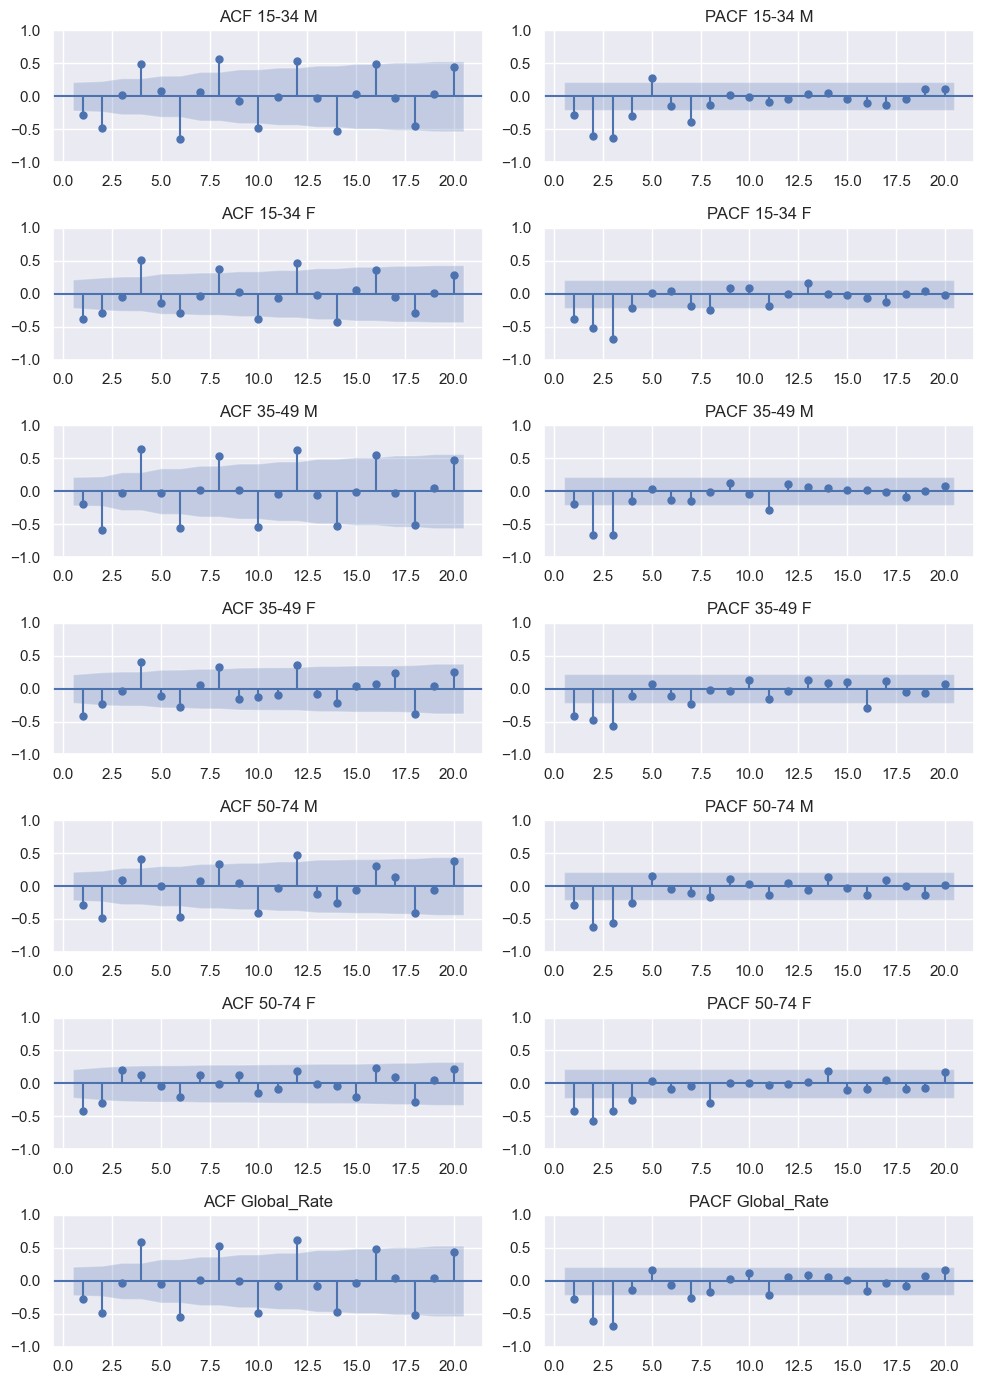

In [349]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

num_vars = len(diff_df2.columns)
fig, axes = plt.subplots(num_vars, 2, figsize=(10, 2 * num_vars))  # 2 columns (ACF and PACF), 1 row for variable

for i, column in enumerate(diff_df2.columns):
    X = diff_df2[column].dropna()

    # ACF
    plot_acf(X, lags=20, ax=axes[i, 0], zero=False)
    axes[i, 0].set_title(f'ACF {column}')

    # PACF
    plot_pacf(X, lags=20, ax=axes[i, 1], zero=False)
    axes[i, 1].set_title(f'PACF {column}')

plt.tight_layout()
plt.show()


NORMALITY FIRST DIFFERENCE

In [350]:
import numpy as np
from scipy import stats

# Create a blank DataFrame to store the results
summary_stats = pd.DataFrame(columns=[
    'nobs', 'nans', 'min', 'max', 'Q1', 'Q3', 'mean', 'median', 'sum', 'SE_mean',
    'LCL_mean', 'UCL_mean', 'variance', 'stdev', 'skewness', 'kurtosis'
])

# Level of confidence
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

for col in diff_df.columns:
    Y = diff_df[col].dropna()
    nobs = len(Y)
    nans = diff_df[col].isna().sum()
    minimum = Y.min()
    maximum = Y.max()
    Q1 = Y.quantile(0.25)
    Q3 = Y.quantile(0.75)
    mean = Y.mean()
    median = Y.median()
    sum_values = Y.sum()
    se_mean = stats.sem(Y)
    margin_of_error = z_score * se_mean
    lcl_mean = mean - margin_of_error
    ucl_mean = mean + margin_of_error
    variance = Y.var()
    stdev = Y.std()
    skewness = stats.skew(Y)
    kurtosis = stats.kurtosis(Y)

    # Add row to summary DataFrame
    summary_stats.loc[col] = [
        nobs, nans, minimum, maximum, Q1, Q3, mean, median, sum_values,
        se_mean, lcl_mean, ucl_mean, variance, stdev, skewness, kurtosis
    ]


summary_stats = summary_stats.round(2)
summary_stats_transposed = summary_stats.T
print(summary_stats_transposed)



          15-34 M  15-34 F  35-49 M  35-49 F  50-74 M  50-74 F  Global_Rate
nobs        84.00    84.00    84.00    84.00    84.00    84.00        84.00
nans         0.00     0.00     0.00     0.00     0.00     0.00         0.00
min         -3.61    -3.48    -1.62    -2.29    -1.33    -1.16        -1.64
max          3.91     4.53     1.52     2.93     1.91     1.57         2.41
Q1          -1.19    -1.30    -0.59    -0.68    -0.36    -0.50        -0.75
Q3           1.44     1.37     0.55     0.68     0.33     0.45         0.78
mean        -0.00    -0.04     0.01    -0.02     0.00    -0.01        -0.02
median      -0.18    -0.39    -0.10    -0.20    -0.08    -0.10        -0.27
sum         -0.08    -3.33     0.67    -1.74     0.07    -0.79        -1.92
SE_mean      0.18     0.19     0.08     0.11     0.07     0.07         0.10
LCL_mean    -0.35    -0.42    -0.15    -0.23    -0.13    -0.15        -0.22
UCL_mean     0.35     0.34     0.16     0.19     0.13     0.13         0.17
variance    

NORMALITY SECOND DIFFERENCE

In [351]:
import numpy as np
from scipy import stats

# Create an empty DataFrame to store the resultss
summary_stats = pd.DataFrame(columns=[
    'nobs', 'nans', 'min', 'max', 'Q1', 'Q3', 'mean', 'median', 'sum', 'SE_mean',
    'LCL_mean', 'UCL_mean', 'variance', 'stdev', 'skewness', 'kurtosis'
])

# Level of Confidence
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

for col in diff_df2.columns:
    Y = diff_df2[col].dropna()
    #nobs = len(Y)
    #nans = diff_df2[col].isna().sum()
    minimum = Y.min()
    maximum = Y.max()
    Q1 = Y.quantile(0.25)
    Q3 = Y.quantile(0.75)
    mean = Y.mean()
    median = Y.median()
    sum_values = Y.sum()
    se_mean = stats.sem(Y)
    margin_of_error = z_score * se_mean
    lcl_mean = mean - margin_of_error
    ucl_mean = mean + margin_of_error
    variance = Y.var()
    stdev = Y.std()
    skewness = stats.skew(Y)
    kurtosis = stats.kurtosis(Y)

    # Add row to summary DataFrame
    summary_stats.loc[col] = [
        nobs, nans, minimum, maximum, Q1, Q3, mean, median, sum_values,
        se_mean, lcl_mean, ucl_mean, variance, stdev, skewness, kurtosis
    ]


summary_stats = summary_stats.round(2)
summary_stats_transposed = summary_stats.T
print(summary_stats_transposed)

          15-34 M  15-34 F  35-49 M  35-49 F  50-74 M  50-74 F  Global_Rate
nobs        84.00    84.00    84.00    84.00    84.00    84.00        84.00
nans         0.00     0.00     0.00     0.00     0.00     0.00         0.00
min         -5.16    -6.96    -2.07    -3.58    -1.96    -1.79        -2.91
max          6.54     6.80     2.77     5.21     2.43     2.55         4.05
Q1          -1.79    -1.92    -0.63    -1.05    -0.57    -0.74        -1.00
Q3           1.78     1.91     0.61     1.12     0.56     0.68         0.84
mean         0.01     0.03     0.01     0.03     0.01     0.02         0.02
median      -0.52    -0.33    -0.15    -0.11    -0.06     0.05        -0.09
sum          1.02     2.48     1.17     2.39     1.24     1.45         1.58
SE_mean      0.26     0.30     0.11     0.16     0.10     0.11         0.15
LCL_mean    -0.50    -0.55    -0.21    -0.29    -0.18    -0.19        -0.27
UCL_mean     0.53     0.61     0.24     0.35     0.21     0.23         0.30
variance    

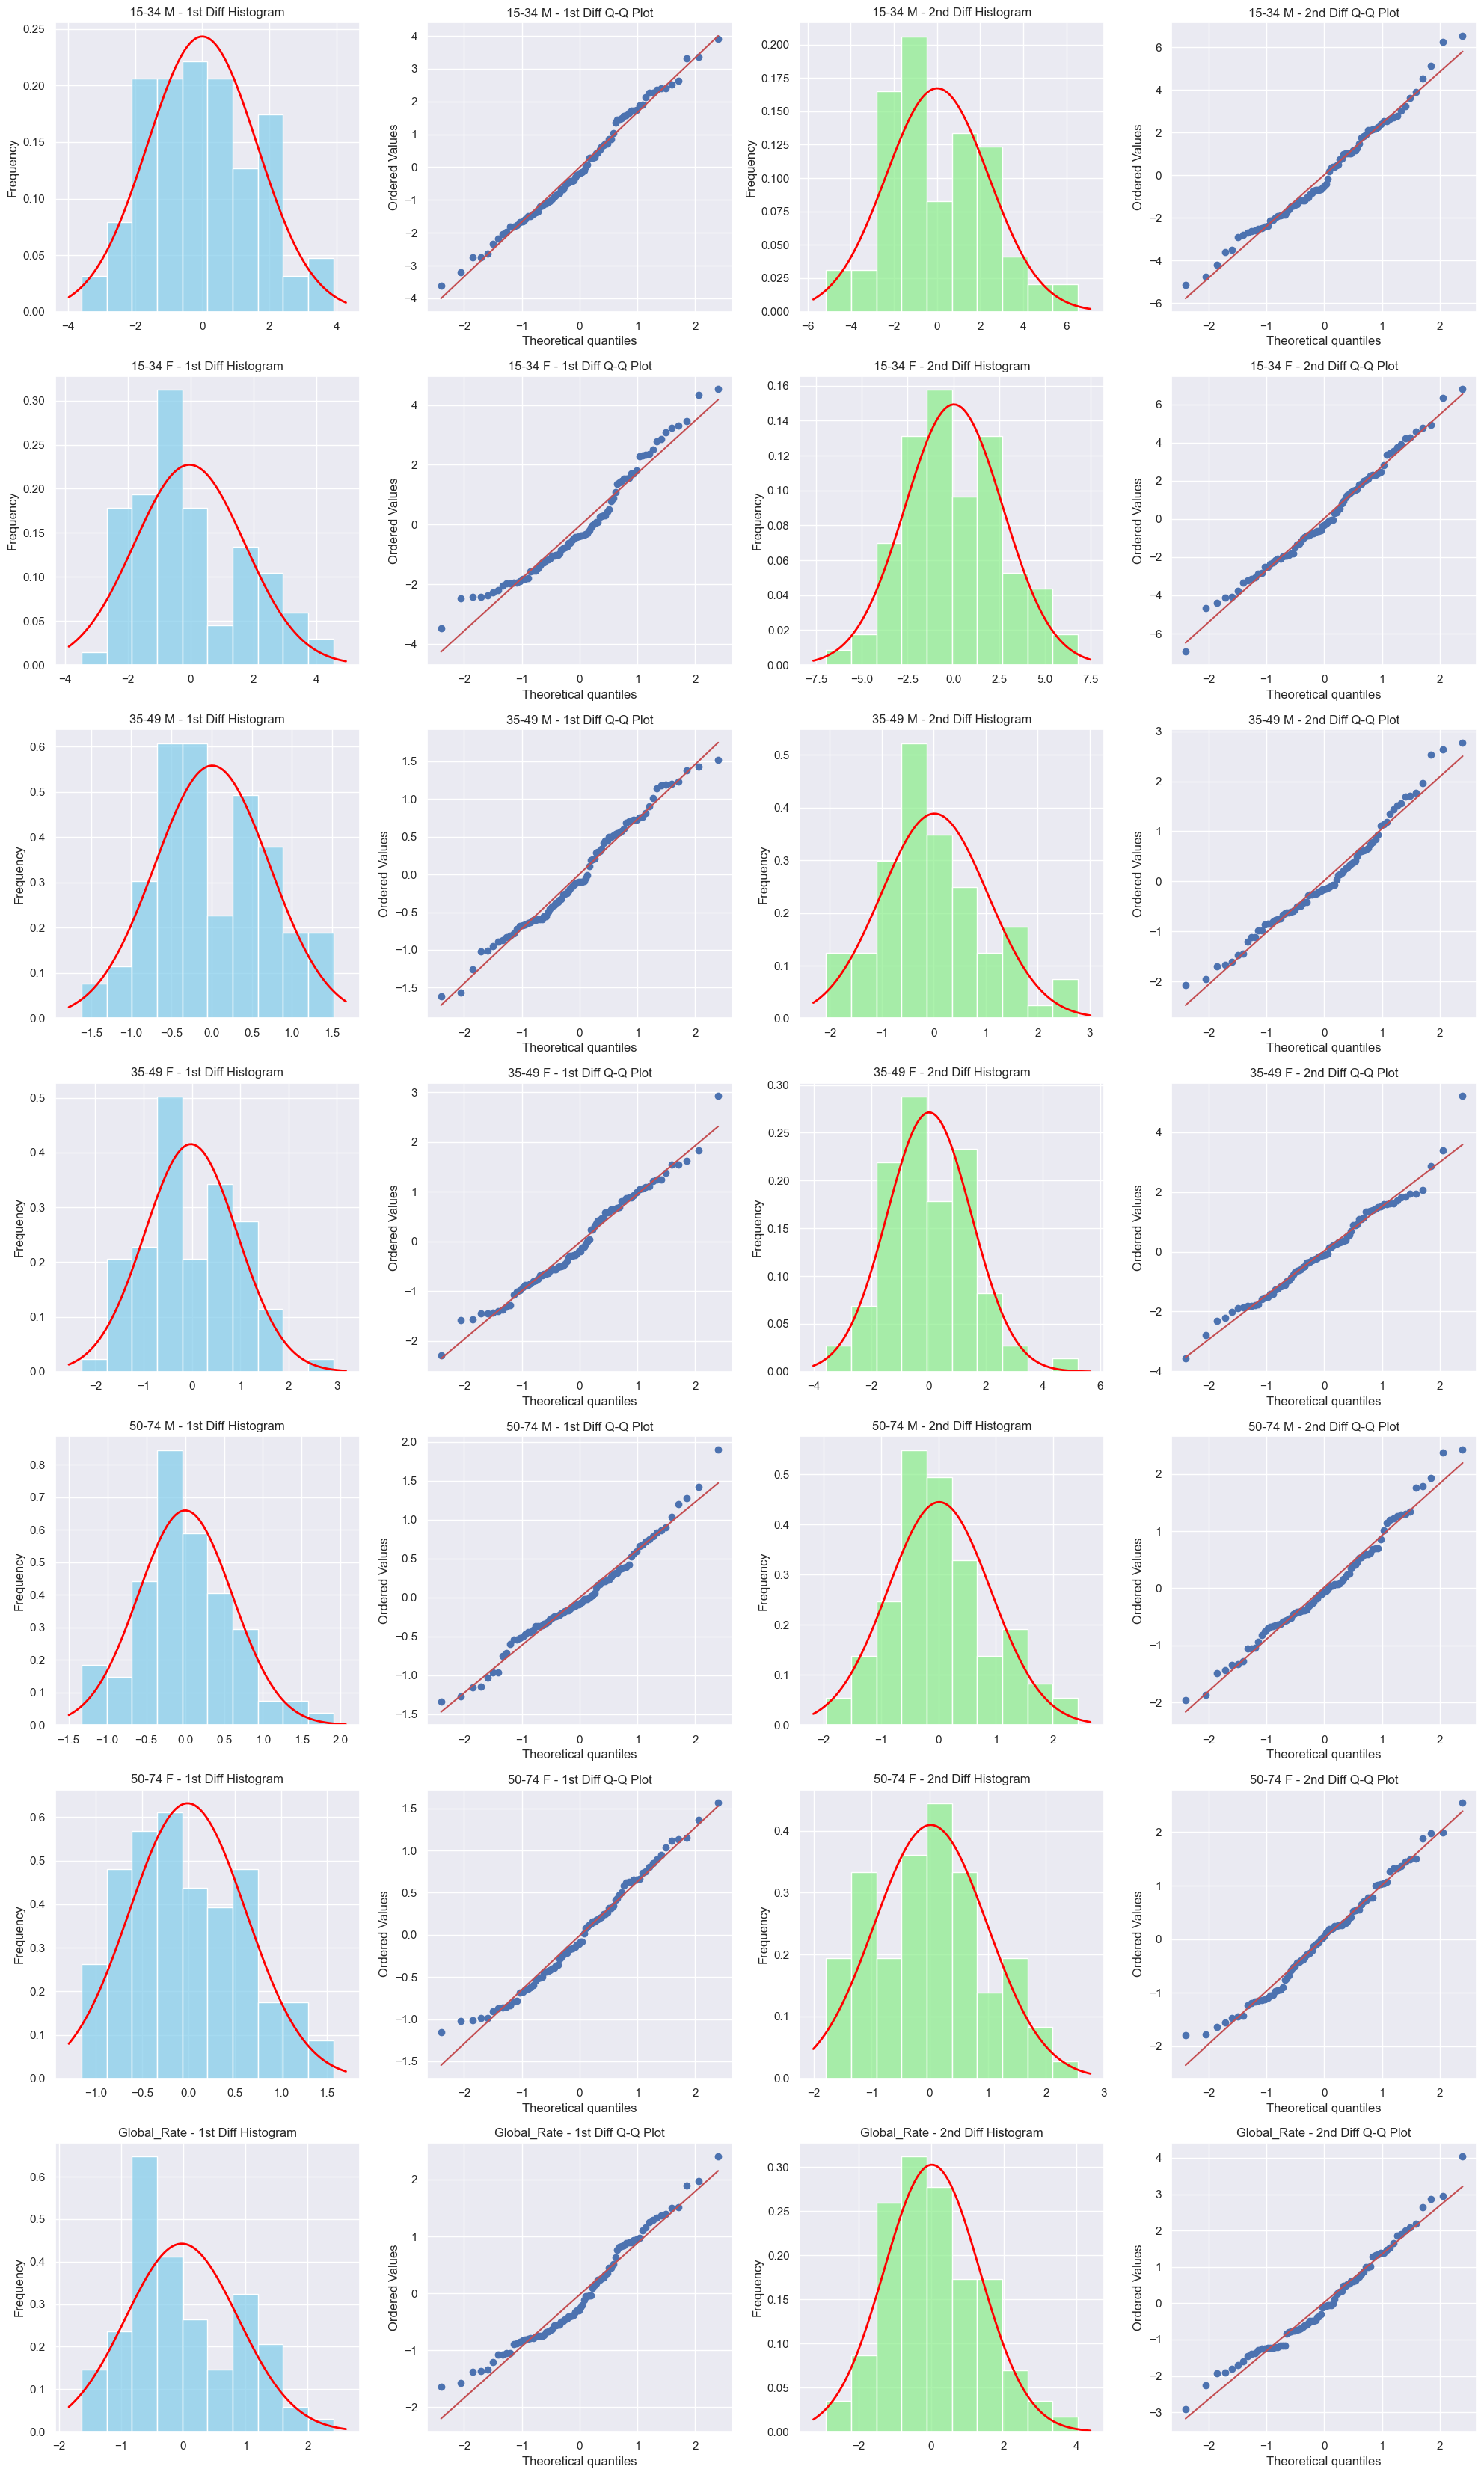

In [352]:
columns = diff_df.columns
n_cols = 4
n_rows = len(columns)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
#fig.suptitle('Comparison of First and Second Differences for All Groups', fontsize=18, y=0.92)

for i, col in enumerate(columns):
    Z1 = diff_df[col].dropna()
    Z2 = diff_df2[col].dropna()

    # First Diff Histogram (column 0)
    sns.histplot(Z1, kde=False, bins=10, stat='density', color='skyblue', ax=axs[i, 0])
    x1 = np.linspace(*axs[i, 0].get_xlim(), 100)
    axs[i, 0].plot(x1, stats.norm.pdf(x1, np.mean(Z1), np.std(Z1)), color='red', lw=2)
    axs[i, 0].set_title(f'{col} - 1st Diff Histogram')
    axs[i, 0].set_xlabel('')
    axs[i, 0].set_ylabel('Frequency')

    # First Diff Q-Q Plot (column 1)
    stats.probplot(Z1, dist="norm", plot=axs[i, 1])
    axs[i, 1].set_title(f'{col} - 1st Diff Q-Q Plot')

    # Second Diff Histogram (column 2)
    sns.histplot(Z2, kde=False, bins=10, stat='density', color='lightgreen', ax=axs[i, 2])
    x2 = np.linspace(*axs[i, 2].get_xlim(), 100)
    axs[i, 2].plot(x2, stats.norm.pdf(x2, np.mean(Z2), np.std(Z2)), color='red', lw=2)
    axs[i, 2].set_title(f'{col} - 2nd Diff Histogram')
    axs[i, 2].set_xlabel('')
    axs[i, 2].set_ylabel('Frequency')

    # Second Diff Q-Q Plot (column 3)
    stats.probplot(Z2, dist="norm", plot=axs[i, 3])
    axs[i, 3].set_title(f'{col} - 2nd Diff Q-Q Plot')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


NORMALITY TEST

In [353]:
results = []

datasets = {'First Difference': diff_df, 'Second Difference': diff_df2}

for name, df in datasets.items():
    for col in df.columns:
        Z = df[col].dropna()
        shapiro_stat, shapiro_p = stats.shapiro(Z)
        jb_stat, jb_p = stats.jarque_bera(Z)
        dagostino_stat, dagostino_p = stats.normaltest(Z)

        results.append({
            'Dataset': name,
            'Column': col,
            'Shapiro-Wilk Stat': round(shapiro_stat, 4),
            'Shapiro-Wilk p-value': round(shapiro_p, 4),
            'Jarque-Bera Stat': round(jb_stat, 4),
            'Jarque-Bera p-value': round(jb_p, 4),
            "D'Agostino Stat": round(dagostino_stat, 4),
            "D'Agostino p-value": round(dagostino_p, 4)
        })

# Convert to DataFrame for a clean table
df_results = pd.DataFrame(results)
print(df_results.sort_values(['Dataset', 'Column']).to_string(index=False))


          Dataset      Column  Shapiro-Wilk Stat  Shapiro-Wilk p-value  Jarque-Bera Stat  Jarque-Bera p-value  D'Agostino Stat  D'Agostino p-value
 First Difference     15-34 F             0.9550                0.0052            5.6582               0.0591           5.5571              0.0621
 First Difference     15-34 M             0.9862                0.5133            1.7516               0.4165           2.3447              0.3096
 First Difference     35-49 F             0.9816                0.2726            1.1030               0.5761           1.1057              0.5753
 First Difference     35-49 M             0.9798                0.2086            1.7000               0.4274           2.5592              0.2781
 First Difference     50-74 F             0.9784                0.1708            2.7265               0.2558           3.7588              0.1527
 First Difference     50-74 M             0.9812                0.2595            2.9918               0.2241         

MODELLATION AND FORCASTING-ARIMA: BEST ARIMA/SARIMA MODELS

In [354]:
import pmdarima as pm

arima_models = {}

for col in disocupati_trimestral.columns:
    series = disocupati_trimestral[col].dropna()  # in case there are missing values
    
    print(f"\nFitting auto_arima for series: {col} ...")
    model = pm.auto_arima(
        series,
        seasonal=True,
        m=4,                 # quarterly frequency
        stepwise=True,       # speed up search
        approximation=False, # for higher accuracy
        suppress_warnings=True,
        error_action='ignore',
        trace=False
    )
    arima_models[col] = model
    
    print(f"Best ARIMA model for {col}: ARIMA{model.order} x Seasonal{model.seasonal_order} (m=4)")
    print(f"AIC: {model.aic():.2f} | BIC: {model.bic():.2f}")

# You can access the fitted models later via:
# arima_models['15-34 M'], etc.



Fitting auto_arima for series: 15-34 M ...
Best ARIMA model for 15-34 M: ARIMA(0, 1, 0) x Seasonal(1, 0, 1, 4) (m=4)
AIC: 267.74 | BIC: 275.03

Fitting auto_arima for series: 15-34 F ...
Best ARIMA model for 15-34 F: ARIMA(2, 1, 3) x Seasonal(1, 0, 0, 4) (m=4)
AIC: 291.06 | BIC: 310.51

Fitting auto_arima for series: 35-49 M ...
Best ARIMA model for 35-49 M: ARIMA(2, 1, 2) x Seasonal(0, 0, 1, 4) (m=4)
AIC: 120.31 | BIC: 134.89

Fitting auto_arima for series: 35-49 F ...
Best ARIMA model for 35-49 F: ARIMA(0, 1, 1) x Seasonal(1, 0, 1, 4) (m=4)
AIC: 201.89 | BIC: 211.61

Fitting auto_arima for series: 50-74 M ...
Best ARIMA model for 50-74 M: ARIMA(2, 1, 1) x Seasonal(1, 0, 1, 4) (m=4)
AIC: 111.37 | BIC: 125.96

Fitting auto_arima for series: 50-74 F ...
Best ARIMA model for 50-74 F: ARIMA(0, 1, 3) x Seasonal(1, 0, 2, 4) (m=4)
AIC: 148.41 | BIC: 167.86

Fitting auto_arima for series: Global_Rate ...
Best ARIMA model for Global_Rate: ARIMA(2, 1, 2) x Seasonal(0, 0, 0, 4) (m=4)
AIC: 158.5

In [355]:
arima_models['15-34 M'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   85
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 4)   Log Likelihood                -130.870
Date:                             Wed, 05 Nov 2025   AIC                            267.740
Time:                                     10:13:34   BIC                            275.033
Sample:                                          0   HQIC                           270.672
                                              - 85                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4        0.9869      0.021     46.912      0.000       0.946       1.028
ma.S.L4       -0.8234      0.103     -7.982      0.000      -1.026      -0.621
sigma2         1.2334      0.129      9.541      0.000       0.980       1.487
===================================================================================
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):                61.14
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               3.60   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA SIN VENTANA DESLIZANTE

In [356]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Custom MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Bootstrapped confidence intervals for any metric
def bootstrap_ci(y_true, y_pred, metric_func, n_boot=1000, alpha=0.05):
    errors = []
    n = len(y_true)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for _ in range(n_boot):
        idx = np.random.choice(range(n), n, replace=True)
        errors.append(metric_func(y_true[idx], y_pred[idx]))
    errors = np.array(errors)
    lower = np.percentile(errors, 100 * alpha / 2)
    upper = np.percentile(errors, 100 * (1 - alpha / 2))
    mean_val = metric_func(y_true, y_pred)
    return mean_val, lower, upper

# Series to evaluate
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]

results = []

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()

    try:
        model = ARIMA(Y, order=(1, 2, 0)) #######Here MODEL (1,2,0)
        model_fit = model.fit()

        pred = model_fit.predict(start=0, end=len(Y) - 1)

        aic = model_fit.aic
        bic = model_fit.bic

        # Get sigma² from model parameters or fallback to residual variance
        sigma2_coef = model_fit.params.get('sigma2', np.var(model_fit.resid))

        # Residual diagnostics
        lb_test = acorr_ljungbox(model_fit.resid, lags=[1], return_df=True)
        lb_pvalue = lb_test["lb_pvalue"].values[0]

        jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(model_fit.resid)

        # Performance metrics with confidence intervals
        mae, mae_low, mae_up = bootstrap_ci(Y, pred, mean_absolute_error)
        mse, mse_low, mse_up = bootstrap_ci(Y, pred, mean_squared_error)
        rmse, rmse_low, rmse_up = bootstrap_ci(Y, pred, lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)))
        mape, mape_low, mape_up = bootstrap_ci(Y, pred, mean_absolute_percentage_error)

        results.append({
            "Series": serie,
            "AIC": aic,
            "BIC": bic,
            "σ² (sigma2 coefficient)": sigma2_coef,
            "Ljung-Box (p-value)": lb_pvalue,
            "Jarque-Bera (p-value)": jb_pvalue,
            "MAE": mae,
            "MAE CI Lower": mae_low,
            "MAE CI Upper": mae_up,
            "MSE": mse,
            "MSE CI Lower": mse_low,
            "MSE CI Upper": mse_up,
            "RMSE": rmse,
            "RMSE CI Lower": rmse_low,
            "RMSE CI Upper": rmse_up,
            "MAPE": mape,
            "MAPE CI Lower": mape_low,
            "MAPE CI Upper": mape_up
        })

    except Exception as e:
        print(f"Error in series {serie}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)




        Series         AIC         BIC  σ² (sigma2 coefficient)  \
0      15-34 M  377.081887  381.919568                 5.238898   
1      15-34 F  389.631178  394.468859                 6.088498   
2      35-49 M  240.567557  245.405238                 1.011911   
3      35-49 F  288.406507  293.244189                 1.797689   
4      50-74 M  214.076677  218.914358                 0.734977   
5      50-74 F  219.495272  224.332953                 0.783627   
6  Global_Rate  279.312054  284.149735                 1.613251   

   Ljung-Box (p-value)  Jarque-Bera (p-value)       MAE  MAE CI Lower  \
0             0.031203           1.177042e-10  2.029009      1.686103   
1             0.004429           2.376536e-55  2.300049      1.859168   
2             0.037457           8.987340e-04  0.847915      0.678126   
3             0.001371           7.113027e-41  1.229389      0.995034   
4             0.016897           5.853312e-07  0.718595      0.580880   
5             0.001565   

ARIMA(1,2 0) CON VENTANA DESLIZANTE = 20

In [357]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import jarque_bera, skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import statsmodels.api as sm

series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = ARIMA(train, order=(1, 2, 0))
            model_fit = model.fit()
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # persistence forecast if fitting fails
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
         np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
         np.mean
    )

    # Final model fitted on full data
    final_model = ARIMA(data, order=(1, 2, 0)).fit()

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test on residuals
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test for normality of residuals
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test: Breusch-Pagan test using residuals and time index as regressor
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))  # time index as exogenous regressor
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]  # Breusch-Pagan p-value

    # Skewness and kurtosis of residuals
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert results to DataFrame
results_df1 = pd.DataFrame(results)



In [358]:
results_df1
results_df1.to_excel("arima_model120_results.xlsx", index=False)

ARIMA(1,2 1) CON VENTANA DESLIZANTE = 20

In [359]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import jarque_bera, skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import statsmodels.api as sm

series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results1 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = ARIMA(train, order=(1, 2, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # persistence forecast if fitting fails
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
         np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
         np.mean
    )

    # Final model fitted on full data
    final_model = ARIMA(data, order=(1, 2, 1)).fit()

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test on residuals
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test for normality of residuals
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test: Breusch-Pagan test using residuals and time index as regressor
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))  # time index as exogenous regressor
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]  # Breusch-Pagan p-value

    # Skewness and kurtosis of residuals
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results1.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert results to DataFrame
results_df2 = pd.DataFrame(results1)
results_df2
results_df2.to_excel("arima_model121_results.xlsx", index=False)


ARIMA(1,2 2) CON VENTANA DESLIZANTE = 20

In [360]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results2 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = ARIMA(train, order=(1, 2, 2))
            model_fit = model.fit()
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # persistence forecast if fitting fails
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
         np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
         np.mean
    )

    # Final model fitted on full data
    final_model = ARIMA(data, order=(1, 2, 2)).fit()

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test on residuals
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test for normality of residuals
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test: Breusch-Pagan test using residuals and time index as regressor
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))  # time index as exogenous regressor
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]  # Breusch-Pagan p-value

    # Skewness and kurtosis of residuals
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results2.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert results to DataFrame
results_df3 = pd.DataFrame(results2)
results_df3
results_df3.to_excel("arima_model122_results.xlsx", index=False)

ARIMA(2,1,1) CON VENTANA DESLIZANTE  = 20

In [361]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results3 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = ARIMA(train, order=(2, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # persistence forecast if fitting fails
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
         np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
         np.mean
    )

    # Final model fitted on full data
    final_model = ARIMA(data, order=(2, 1, 1)).fit()

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test on residuals
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test for normality of residuals
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test: Breusch-Pagan test using residuals and time index as regressor
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))  # time index as exogenous regressor
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]  # Breusch-Pagan p-value

    # Skewness and kurtosis of residuals
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results3.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert results to DataFrame
results_df4 = pd.DataFrame(results3)
results_df4
results_df4.to_excel("arima_model211_results.xlsx", index=False)

ARIMA(2,2,1) CON VENTANA DESLIZANTE = 20

In [362]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results4 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = ARIMA(train, order=(2, 2, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # persistence forecast if fitting fails
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
         np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
         np.mean
    )

    # Final model fitted on full data
    final_model = ARIMA(data, order=(2, 2, 1)).fit()

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test on residuals
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test for normality of residuals
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test: Breusch-Pagan test using residuals and time index as regressor
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))  # time index as exogenous regressor
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]  # Breusch-Pagan p-value

    # Skewness and kurtosis of residuals
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results4.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert results to DataFrame
results_df5 = pd.DataFrame(results4)
results_df5
results_df5.to_excel("arima_model221_results.xlsx", index=False)

ARIMA (2,1,2) CON VENTANA DESLIZANTE = 20

In [363]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results5 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = ARIMA(train, order=(2, 1, 2))
            model_fit = model.fit()
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # persistence forecast if fitting fails
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
         np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
         np.mean
    )

    # Final model fitted on full data
    final_model = ARIMA(data, order=(2, 1, 2)).fit()

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test on residuals
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test for normality of residuals
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test: Breusch-Pagan test using residuals and time index as regressor
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))  # time index as exogenous regressor
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]  # Breusch-Pagan p-value

    # Skewness and kurtosis of residuals
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results5.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert results to DataFrame
results_df6 = pd.DataFrame(results5)
results_df6
results_df6.to_excel("arima_model212_results.xlsx", index=False)

SARIMA(0,1,0)(1,0,1) CON VENTANA DESLIZANTE = 20 (15-34M)

In [364]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import jarque_bera, skew, kurtosis
import statsmodels.api as sm

series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results6 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(1, 0, 1, 4), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # fallback forecast
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
        np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
        np.mean
    )

    # Final model on full data
    final_model = SARIMAX(data, order=(0, 1, 0), seasonal_order=(1, 0, 1, 4), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]

    # Skewness and kurtosis
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results6.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert to DataFrame and export
results_df7 = pd.DataFrame(results6)
results_df7.to_excel("sarimax_010_1014_results.xlsx", index=False)


In [365]:
results_df7

Series         AIC         BIC  σ² (sigma2 coefficient)  \
0      15-34 M  251.439624  258.547967                 3.238243   
1      15-34 F  280.102337  287.210680                 6.140469   
2      35-49 M  115.813874  122.922218                 0.481090   
3      35-49 F  197.012069  204.120412                 1.771347   
4      50-74 M  117.473498  124.581842                 0.466479   
5      50-74 F  148.185773  155.294116                 0.739042   
6  Global_Rate  152.283680  159.392024                 1.473872   

   Ljung-Box (p-value)  Jarque-Bera (p-value)  Heteroscedasticity (p-value)  \
0             0.525199           0.000000e+00                      0.078989   
1             0.487632           0.000000e+00                      0.072250   
2             0.721353          3.876660e-220                      0.109031   
3             0.271473           0.000000e+00                      0.079674   
4             0.387950          7.408253e-150                      0.080474   
5             0.544305          1.524749e-212                      0.047155   
6             0.445412           0.000000e+00                      0.060517   

       Skew   Kurtosis       MAE  ...  MAE CI Upper       MSE  MSE CI Lower  \
0  3.119664  20.591043  0.962670  ...      1.177777  1.693055      0.950417   
1  3.501046  26.650028  1.092088  ...      1.399200  2.431077      1.248512   
2  2.744070  15.974276  0.410438  ...      0.499385  0.297947      0.191733   
3  3.051051  21.147209  0.655256  ...      0.803534  0.792667      0.455803   
4  2.227313  13.193481  0.413976  ...      0.501775  0.299446      0.187052   
5  2.737747  15.666551  0.532008  ...      0.621264  0.414645      0.289994   
6  4.070864  31.036641  0.484772  ...      0.607851  0.466116      0.227609   

   MSE CI Upper      RMSE  RMSE CI Lower  RMSE CI Upper       MAPE  \
0      2.730256  1.301175       0.983691       1.663762   5.782592   
1      4.103207  1.559191       1.112682       1.976882   5.747570   
2      0.442678  0.545846       0.436105       0.665715   6.072313   
3      1.276263  0.890318       0.667093       1.122055   7.325852   
4      0.444037  0.547216       0.433387       0.668034   7.740387   
5      0.562740  0.643930       0.531249       0.752873  10.509994   
6      0.820283  0.682727       0.483460       0.946515   5.089729   

   MAPE CI Lower  MAPE CI Upper  
0       4.584999       7.086866  
1       4.284275       7.326491  
2       4.925808       7.383341  
3       5.769934       8.927998  
4       6.047287       9.476033  
5       8.607446      12.410370  
6       4.004626       6.341728  

[7 rows x 21 columns]

SARIMA(2,1,3)(1,0,0) CON VENTANA DESLIZANTE = 20 (15-34F)

In [366]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results7 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = SARIMAX(train, order=(2, 1, 3), seasonal_order=(1, 0, 0, 4), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # fallback forecast
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
        np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
        np.mean
    )

    # Final model on full data
    final_model = SARIMAX(data, order=(2, 1, 3), seasonal_order=(1, 0, 0, 4), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]

    # Skewness and kurtosis
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results7.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert to DataFrame and export
results_df8 = pd.DataFrame(results7)
results_df8.to_excel("sarimax_213_1004_results.xlsx", index=False)

In [367]:
results_df8

Series         AIC         BIC  σ² (sigma2 coefficient)  \
0      15-34 M  250.772377  267.269339                 2.978074   
1      15-34 F  272.066464  288.563425                 5.764321   
2      35-49 M  118.118669  134.615630                 0.470340   
3      35-49 F  187.108018  203.604980                 1.642242   
4      50-74 M  108.811962  125.308924                 0.410861   
5      50-74 F  134.065346  150.562308                 0.671939   
6  Global_Rate  151.688613  168.185575                 1.402337   

   Ljung-Box (p-value)  Jarque-Bera (p-value)  Heteroscedasticity (p-value)  \
0             0.505094           0.000000e+00                      0.081477   
1             0.597720           0.000000e+00                      0.058214   
2             0.866700          1.082162e-224                      0.074783   
3             0.334843           0.000000e+00                      0.056410   
4             0.753299          6.100667e-222                      0.071179   
5             0.296263           0.000000e+00                      0.047785   
6             0.445654           0.000000e+00                      0.054807   

       Skew   Kurtosis       MAE  ...  MAE CI Upper       MSE  MSE CI Lower  \
0  3.757981  22.264833  1.031177  ...      1.275412  1.944707      1.254050   
1  4.613189  28.895428  1.203802  ...      1.455340  2.512528      1.585785   
2  3.050380  15.937365  0.457512  ...      0.566939  0.381846      0.248741   
3  4.013754  23.791343  0.663487  ...      0.809717  0.802947      0.469756   
4  3.150018  15.746468  0.442291  ...      0.535167  0.332198      0.216790   
5  3.350697  19.102456  0.477259  ...      0.575003  0.386829      0.242640   
6  5.057936  32.578761  0.538157  ...      0.650883  0.498508      0.293083   

   MSE CI Upper      RMSE  RMSE CI Lower  RMSE CI Upper      MAPE  \
0      2.837341  1.394528       1.093664       1.712827  6.186130   
1      3.739160  1.585096       1.254532       1.925341  6.502819   
2      0.557812  0.617937       0.486884       0.731336  6.758750   
3      1.211841  0.896073       0.688320       1.107006  7.407918   
4      0.472324  0.576366       0.453054       0.691524  8.307605   
5      0.573643  0.621956       0.498961       0.753858  9.543860   
6      0.830865  0.706051       0.536935       0.899016  5.656573   

   MAPE CI Lower  MAPE CI Upper  
0       4.911213       7.624493  
1       5.127185       8.018070  
2       5.435686       8.218907  
3       5.805425       9.119041  
4       6.668995      10.047698  
5       7.497193      11.671140  
6       4.612525       6.783807  

[7 rows x 21 columns]

SARIMA(2,1,2)(0,0,1)  CON VENTANA DESLIZANTE = 20 (35-49M)

In [368]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results8 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 0, 1, 4), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # fallback forecast
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
        np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
        np.mean
    )

    # Final model on full data
    final_model = SARIMAX(data, order=(2, 1, 2), seasonal_order=(0, 0, 1, 4), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]

    # Skewness and kurtosis
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results8.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert to DataFrame and export
results_df9 = pd.DataFrame(results8)
results_df9.to_excel("sarimax_212_0014_results.xlsx", index=False)

SARIMA(0,1,1)(1,0,1)  CON VENTANA DESLIZANTE = 20 (35-49F)

In [369]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results10 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(1, 0, 1, 4), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # fallback forecast
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
        np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
        np.mean
    )

    # Final model on full data
    final_model = SARIMAX(data, order=(0, 1, 1), seasonal_order=(1, 0, 1, 4), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]

    # Skewness and kurtosis
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results10.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert to DataFrame and export
results_df10 = pd.DataFrame(results10)
results_df10.to_excel("sarimax_011_1014_results.xlsx", index=False)

SARIMA(2,1,1)(1,0,1)  CON VENTANA DESLIZANTE = 20 (50-74M)

In [370]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results11 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 0, 1, 4), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # fallback forecast
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
        np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
        np.mean
    )

    # Final model on full data
    final_model = SARIMAX(data, order=(2, 1, 1), seasonal_order=(1, 0, 1, 4), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]

    # Skewness and kurtosis
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results11.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert to DataFrame and export
results_df11 = pd.DataFrame(results11)
results_df11.to_excel("sarimax_211_1014_results.xlsx", index=False)

SARIMA(0,1,3)(1,0,2)  CON VENTANA DESLIZANTE = 20 (50-74F)

In [371]:
series_names = ["15-34 M", "15-34 F", "35-49 M", "35-49 F", "50-74 M", "50-74 F", "Global_Rate"]
results12 = []

# Bootstrap confidence interval function
def bootstrap_ci(errors, metric_func, n_bootstrap=1000, alpha=0.05):
    metrics = []
    n = len(errors)
    for _ in range(n_bootstrap):
        sample = np.random.choice(errors, size=n, replace=True)
        metrics.append(metric_func(sample))
    lower = np.percentile(metrics, 100 * alpha / 2)
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    return lower, upper

for serie in series_names:
    Y = disocupati_trimestral[serie].dropna()
    data = Y.values
    start_train = 20

    predictions = []
    test_real = []
    errors = []

    for t in range(start_train, len(data)):
        train = data[:t]
        actual = data[t]

        try:
            model = SARIMAX(train, order=(0, 1, 3), seasonal_order=(1, 0, 2, 4), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast()[0]
        except:
            forecast = train[-1]  # fallback forecast
        predictions.append(forecast)
        test_real.append(actual)
        errors.append(actual - forecast)

    # Evaluation metrics
    mae = mean_absolute_error(test_real, predictions)
    mse = mean_squared_error(test_real, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real))) * 100

    # Bootstrap confidence intervals
    mae_low, mae_up = bootstrap_ci(np.abs(np.array(errors)), np.mean)
    mse_low, mse_up = bootstrap_ci(np.square(errors), np.mean)
    rmse_low, rmse_up = bootstrap_ci(np.square(errors), lambda x: np.sqrt(np.mean(x)))
    mape_low, mape_up = bootstrap_ci(
        np.abs((np.array(test_real) - np.array(predictions)) / np.array(test_real)) * 100,
        np.mean
    )

    # Final model on full data
    final_model = SARIMAX(data, order=(0, 1, 3), seasonal_order=(1, 0, 2, 4), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    aic = final_model.aic
    bic = final_model.bic
    sigma2_coef = np.var(final_model.resid, ddof=1)

    # Ljung-Box test
    lb_test = acorr_ljungbox(final_model.resid, lags=[10], return_df=True)
    lb_pvalue = lb_test["lb_pvalue"].iloc[0]

    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(final_model.resid)

    # Heteroscedasticity test
    resid = final_model.resid
    exog = sm.add_constant(np.arange(len(resid)))
    bp_test = het_breuschpagan(resid, exog)
    hetero_pvalue = bp_test[1]

    # Skewness and kurtosis
    skewness = skew(final_model.resid)
    kurt = kurtosis(final_model.resid)

    # Store results
    results12.append({
        "Series": serie,
        "AIC": aic,
        "BIC": bic,
        "σ² (sigma2 coefficient)": sigma2_coef,
        "Ljung-Box (p-value)": lb_pvalue,
        "Jarque-Bera (p-value)": jb_pvalue,
        "Heteroscedasticity (p-value)": hetero_pvalue,
        "Skew": skewness,
        "Kurtosis": kurt,
        "MAE": mae,
        "MAE CI Lower": mae_low,
        "MAE CI Upper": mae_up,
        "MSE": mse,
        "MSE CI Lower": mse_low,
        "MSE CI Upper": mse_up,
        "RMSE": rmse,
        "RMSE CI Lower": rmse_low,
        "RMSE CI Upper": rmse_up,
        "MAPE": mape,
        "MAPE CI Lower": mape_low,
        "MAPE CI Upper": mape_up
    })

# Convert to DataFrame and export
results_df12 = pd.DataFrame(results12)
results_df12.to_excel("sarimax_013_1024_results.xlsx", index=False)

RESID 

Processing series: 15-34 M
Processing series: 15-34 F
Processing series: 35-49 M
Processing series: 35-49 F
Processing series: 50-74 M
Processing series: 50-74 F
Processing series: Global_Rate


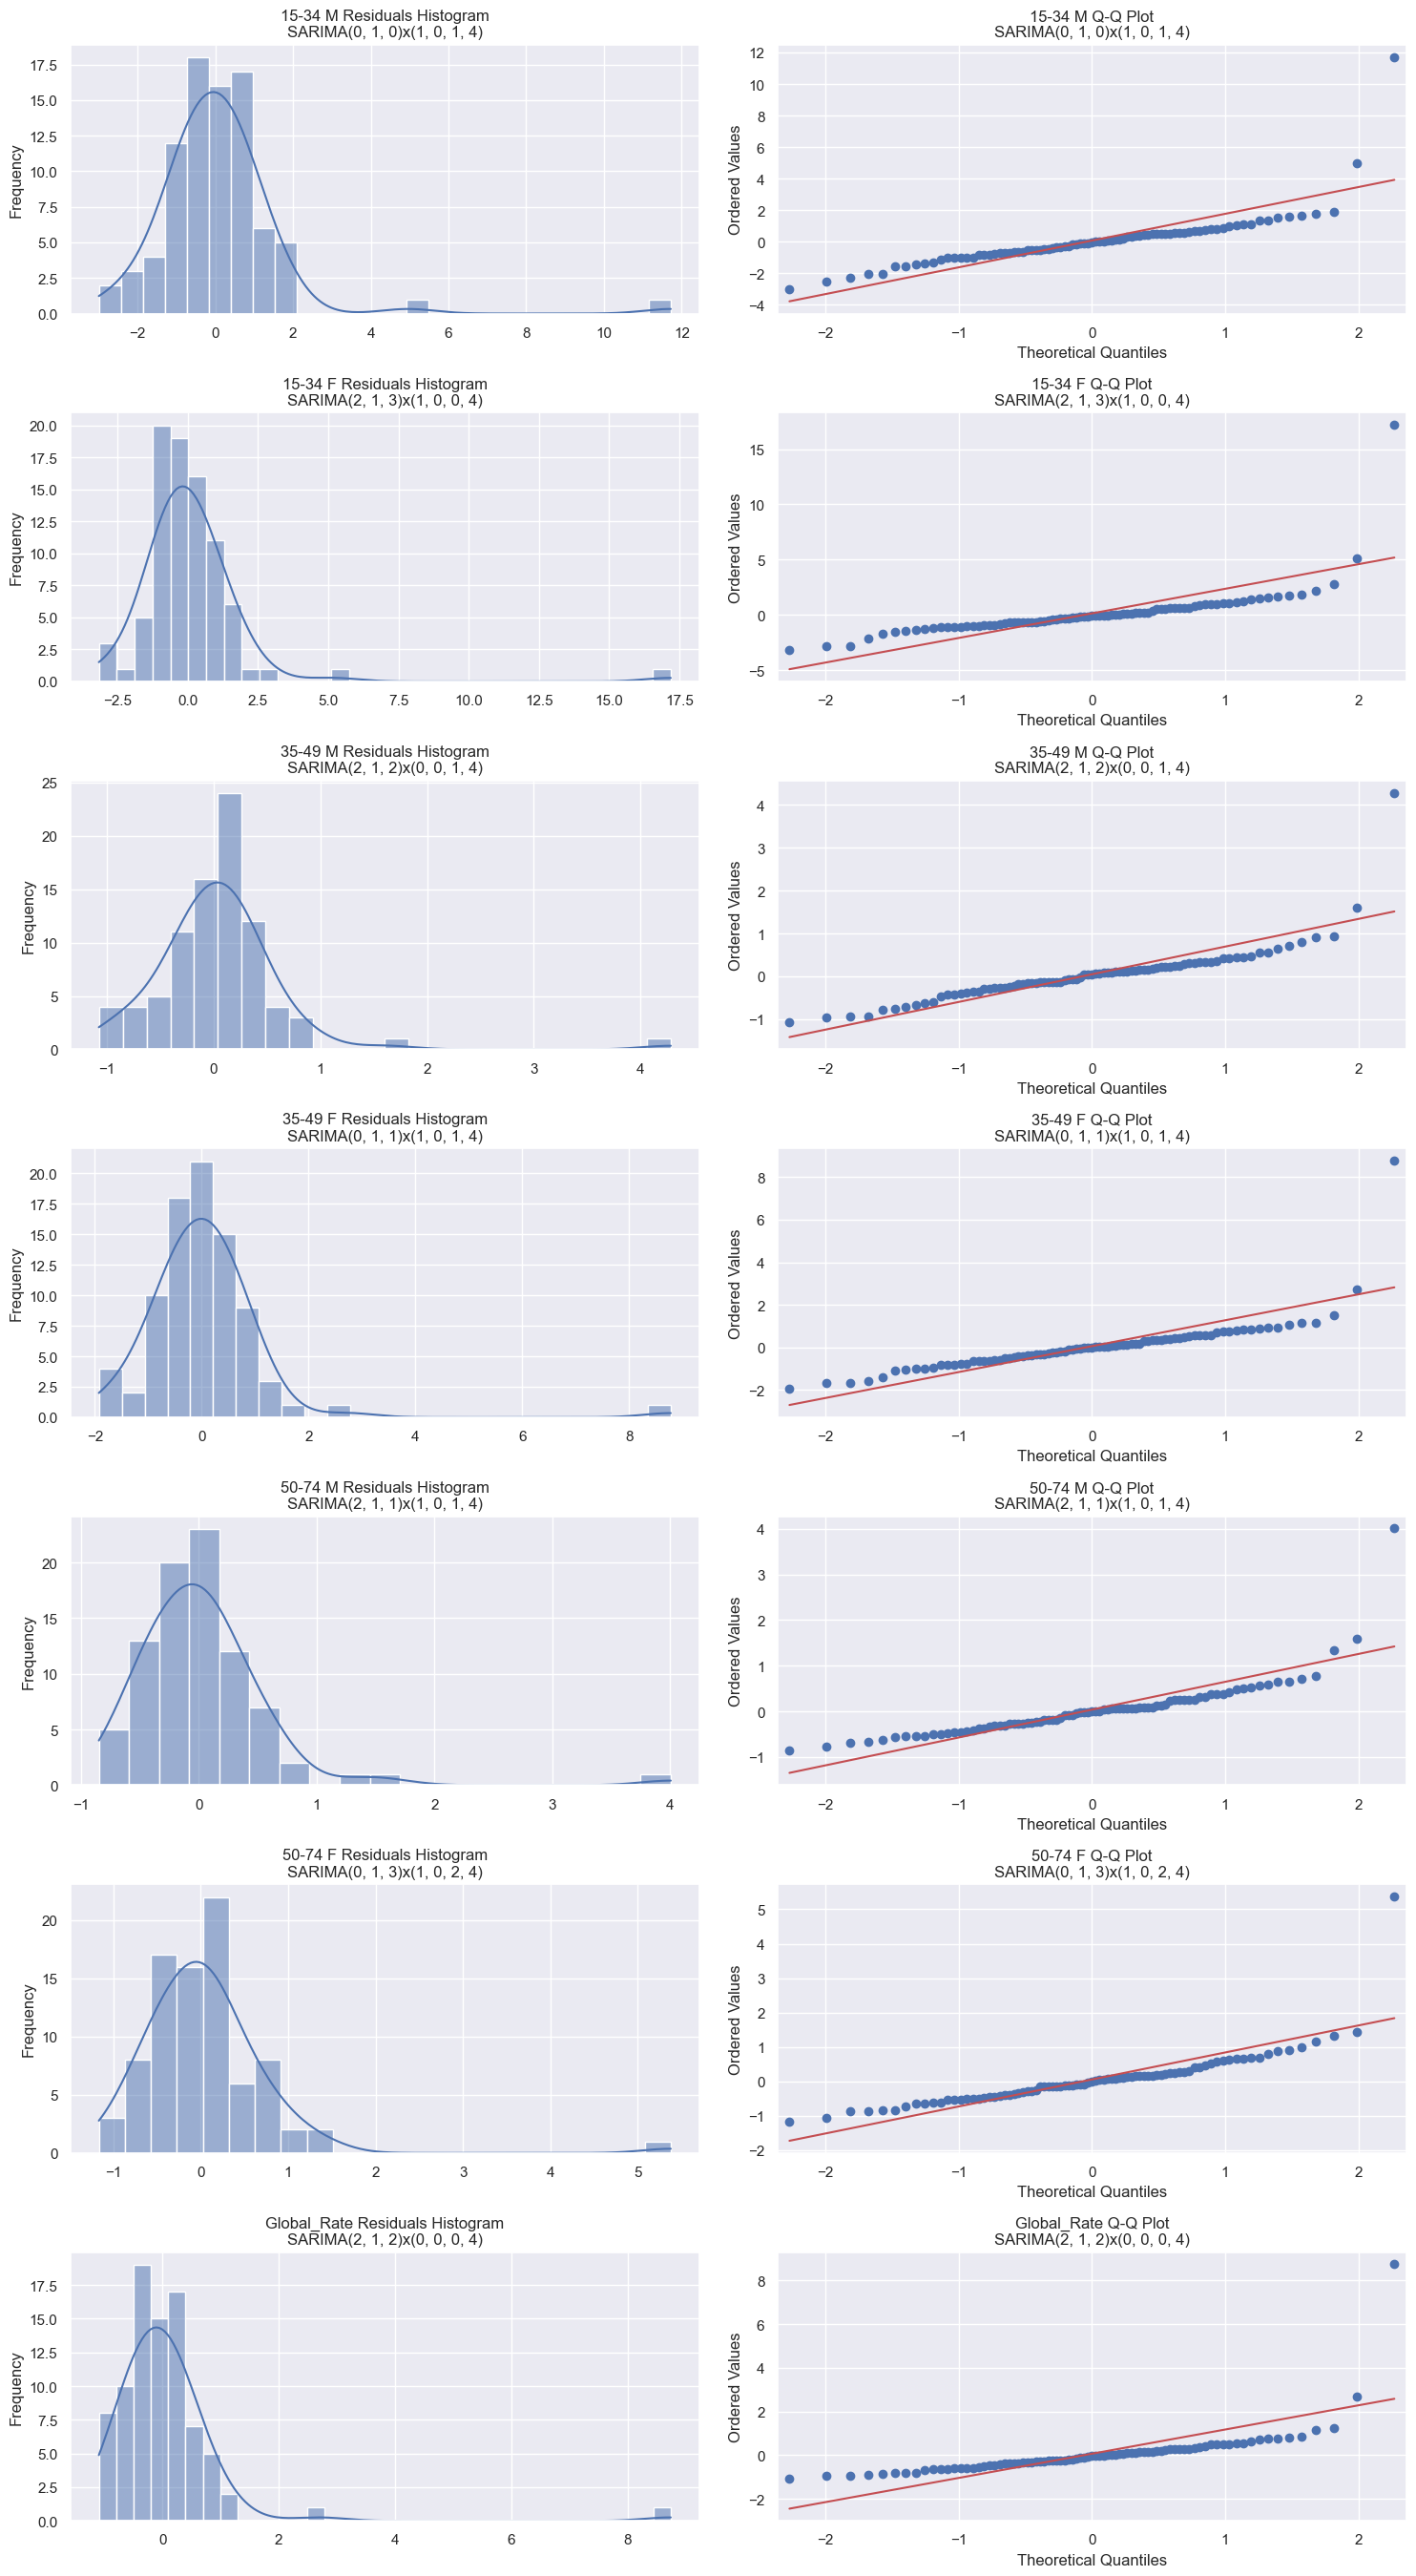


Normality & Independence Tests Summary:
             Shapiro-Wilk p  D’Agostino p  Jarque-Bera p  Ljung-Box p (lag 5)  \
15-34 M        3.574060e-12  8.737701e-24            0.0             0.803574   
15-34 F        1.474142e-14  1.130036e-29            0.0             0.973536   
35-49 M        8.603812e-11  5.842419e-21            0.0             0.858368   
35-49 F        1.234835e-12  1.516974e-25            0.0             0.921350   
50-74 M        5.011803e-11  2.441936e-21            0.0             0.958751   
50-74 F        2.644799e-11  9.619606e-23            0.0             0.891452   
Global_Rate    3.202697e-15  4.604599e-31            0.0             0.990449   

             Ljung-Box p (lag 10)  Ljung-Box p (lag 15)  Ljung-Box p (lag 20)  
15-34 M                  0.943685              0.995420              0.999467  
15-34 F                  0.999357              0.999976              0.999999  
35-49 M                  0.991320              0.997780              0

In [372]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox  # <- Ljung-Box
from scipy.stats import shapiro, normaltest

sns.set_theme(style="darkgrid")

models = {
    '15-34 M': {'order': (0,1,0), 'seasonal_order': (1,0,1,4)},
    '15-34 F': {'order': (2,1,3), 'seasonal_order': (1,0,0,4)},
    '35-49 M': {'order': (2,1,2), 'seasonal_order': (0,0,1,4)},
    '35-49 F': {'order': (0,1,1), 'seasonal_order': (1,0,1,4)},
    '50-74 M': {'order': (2,1,1), 'seasonal_order': (1,0,1,4)},
    '50-74 F': {'order': (0,1,3), 'seasonal_order': (1,0,2,4)},
    'Global_Rate': {'order': (2,1,2), 'seasonal_order': (0,0,0,4)},
}

test_results = {}

fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(15, 4*len(models)))

for i, (series_name, params) in enumerate(models.items()):
    print(f"Processing series: {series_name}")
    try:
        model = SARIMAX(disocupati_trimestral[series_name],
                        order=params['order'],
                        seasonal_order=params['seasonal_order'])
        result = model.fit(disp=False)

        residuals = result.resid.dropna()
        model_desc = f"SARIMA{params['order']}x{params['seasonal_order']}"

        # Histograma + KDE
        sns.histplot(residuals, kde=True, ax=axes[i,0])
        axes[i,0].set_title(f'{series_name} Residuals Histogram\n{model_desc}')
        axes[i,0].set_ylabel('Frequency')

        # Q-Q plot
        sm.qqplot(residuals, line='s', ax=axes[i,1])
        axes[i,1].set_title(f'{series_name} Q-Q Plot\n{model_desc}')
        axes[i,1].set_ylabel('Ordered Values')

        # Pruebas de normalidad
        shapiro_p  = shapiro(residuals).pvalue
        dagostino_p = normaltest(residuals).pvalue
        jb_stat, jb_p, _, _ = jarque_bera(residuals)

        # Ljung-Box para varios lags
        lb_test = acorr_ljungbox(residuals, lags=[5, 10, 15, 20], return_df=True)

        test_results[series_name] = {
            'Shapiro-Wilk p': shapiro_p,
            'D’Agostino p': dagostino_p,
            'Jarque-Bera p': jb_p,
            'Ljung-Box p (lag 5)': lb_test['lb_pvalue'].iloc[0],
            'Ljung-Box p (lag 10)': lb_test['lb_pvalue'].iloc[1],
            'Ljung-Box p (lag 15)': lb_test['lb_pvalue'].iloc[2],
            'Ljung-Box p (lag 20)': lb_test['lb_pvalue'].iloc[3],
        }

    except Exception as e:
        print(f"Error processing series {series_name}: {e}")
        axes[i,0].axis('off')
        axes[i,1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


results_df = pd.DataFrame(test_results).T
print("\nNormality & Independence Tests Summary:")
print(results_df)




FORECAST Best Models SARIMA

In [373]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

window_size = 20
forecast_steps = 4

forecasts = {series: [] for series in models.keys()}

for series_name, params in models.items():
    series_data = disocupati_trimestral[series_name]
    n = len(series_data)
    
    for step in range(forecast_steps):
        start_idx = n - window_size + step
        end_idx = n + step
        
        train_data = series_data.iloc[start_idx:end_idx]
        
        if series_name in ['Global_Rate']:
            model = ARIMA(train_data, order=params['order'])
            result = model.fit()
        else:
            model = SARIMAX(train_data, order=params['order'], seasonal_order=params['seasonal_order'])
            result = model.fit(disp=False)
        
        forecast = result.forecast(steps=1)
        
        # Extract first predicted value with iloc to avoid index errors
        forecast_value = forecast.iloc[0]
        
        forecasts[series_name].append(forecast_value)

forecast_df = pd.DataFrame(forecasts, index=[84, 85, 86, 87])
print(forecast_df)



      15-34 M    15-34 F   35-49 M   35-49 F   50-74 M   50-74 F  Global_Rate
84  11.656846  13.319769  4.922834  6.953373  4.034638  4.254390     6.538483
85   9.905294  12.469112  4.356186  6.467186  3.940188  3.924749     6.366049
86   9.900170  12.957364  4.408384  6.493014  4.011616  3.989232     6.420259
87  10.386675  12.914735  4.404115  6.515306  3.962068  3.961680     6.684693


In [374]:
new_quarters = ['2025-Q2', '2025-Q3', '2025-Q4', '2026-Q1']

# Assign these indices to forecast_df
forecast_df.index = new_quarters

# Concatenate with the original dataset
disocupati_extended = pd.concat([disocupati_trimestral, forecast_df])

disocupati_extended = disocupati_extended.sort_index()

print(disocupati_extended.tail(10))


             15-34 M    15-34 F   35-49 M   35-49 F   50-74 M   50-74 F  \
2023-Q4    12.463177  14.794626  5.570218  8.173678  4.135628  5.213132   
2024-Q1    12.365911  14.369536  5.682832  8.537508  4.504719  5.837779   
2024-Q2    10.868221  13.000800  4.814713  7.091986  4.057952  4.814553   
2024-Q3    10.391842  10.590439  4.218075  5.802678  3.030988  3.656154   
2024-Q4    10.925559  12.400330  4.410602  6.221986  3.202396  4.001726   
2025-Q1    11.640231  13.868486  4.948448  7.037018  4.070563  4.589607   
2025-Q2    11.656846  13.319769  4.922834  6.953373  4.034638  4.254390   
2025-Q3     9.905294  12.469112  4.356186  6.467186  3.940188  3.924749   
2025-Q4     9.900170  12.957364  4.408384  6.493014  4.011616  3.989232   
2026-Q1    10.386675  12.914735  4.404115  6.515306  3.962068  3.961680   

           Global_Rate  
2023-Q4       7.549762  
2024-Q1       7.728341  
2024-Q2       6.676092  
2024-Q3       5.602594  
2024-Q4       6.052437  
2025-Q1       6.820864  

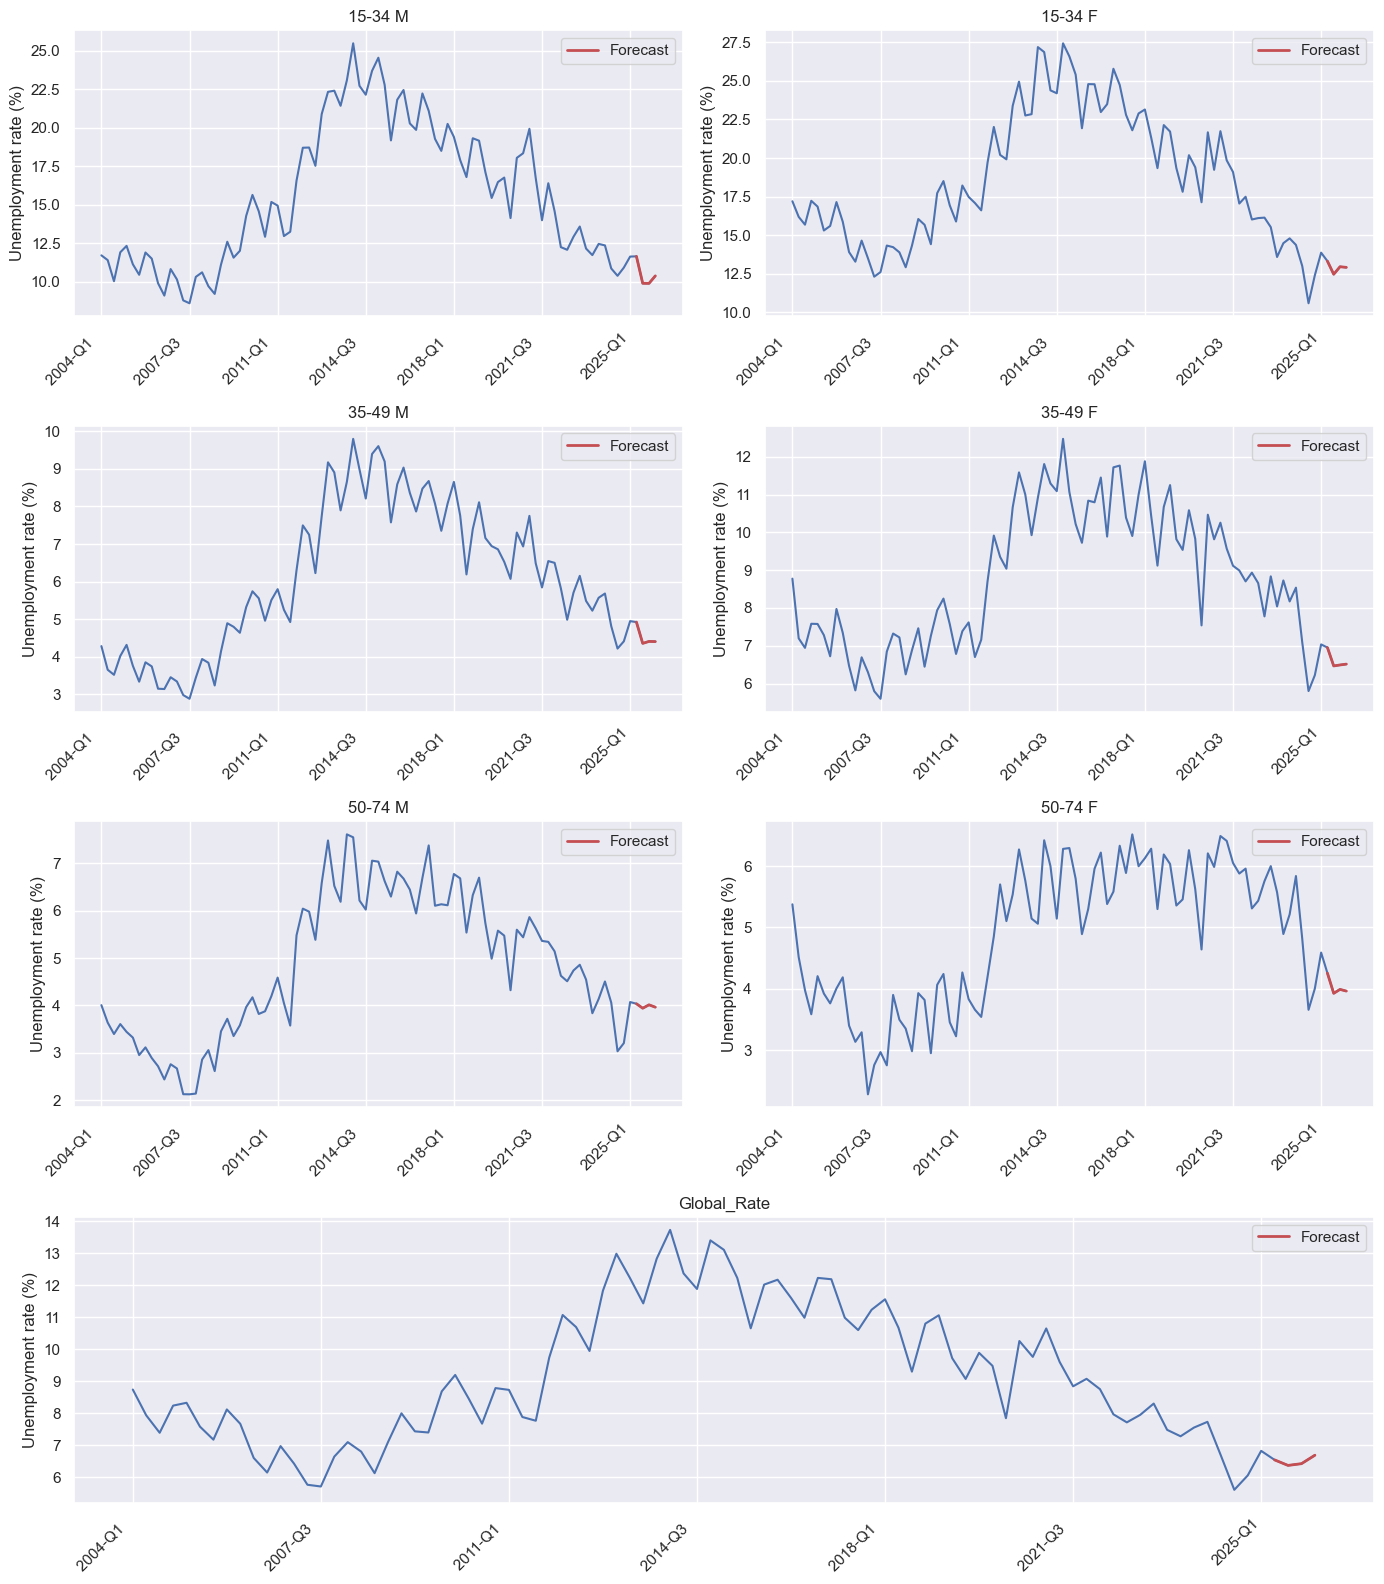

In [375]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and series names
quarters_labels = disocupati_extended.index.to_list()
series_names = disocupati_extended.columns.to_list()
n_series = len(series_names)

# Define historical window size and number of forecast points
window_size = len(disocupati_trimestral)  # original historical size
forecast_steps = 4  # number of forecasted quarters

# Determine number of subplot rows
n_rows = (n_series // 2) + (n_series % 2)

# Initialize figure
fig = plt.figure(figsize=(14, 4 * n_rows))

# Loop through each series to create individual subplots
for i, series_name in enumerate(series_names):
    if (i == n_series - 1) and (n_series % 2 == 1):
        # Last plot spans two columns if the number of series is odd
        ax = plt.subplot2grid((n_rows, 2), (n_rows-1, 0), colspan=2)
    else:
        ax = plt.subplot(n_rows, 2, i+1)

    series_data = disocupati_extended[series_name]

    # Create numeric index for plotting
    x = np.arange(len(series_data))

    # Plot the full series
    ax.plot(x, series_data.values)

    # Highlight the last 4 forecast values in red
    ax.plot(x[-forecast_steps:], series_data.values[-forecast_steps:], 'r-', linewidth=2, label='Forecast')

    # Set uniform x-axis labels across all plots
    step_label = max(1, len(x) // 6)
    ax.set_xticks(x[::step_label])
    ax.set_xticklabels([quarters_labels[j] for j in range(0, len(x), step_label)],
                       rotation=45, ha='right')

    ax.set_title(series_name)
    ax.set_ylabel('Unemployment rate (%)')
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


RNN

In [376]:
import warnings
warnings.filterwarnings("ignore")

# ---------- Import libraries ----------
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # <-- Import seaborn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.layers import LSTM


Columns to process: ['15-34 M', '15-34 F', '35-49 M', '35-49 F', '50-74 M', '50-74 F', 'Global_Rate']

=== Training on column: 15-34 M ===
MAE=1.346  MSE=2.451  RMSE=1.565  MAPE=10.03%
    IC95% MAE : [0.941, 1.701]
    IC95% MSE : [1.383, 3.562]
    IC95% RMSE: [1.176, 1.887]
    IC95% MAPE: [7.19, 12.89]


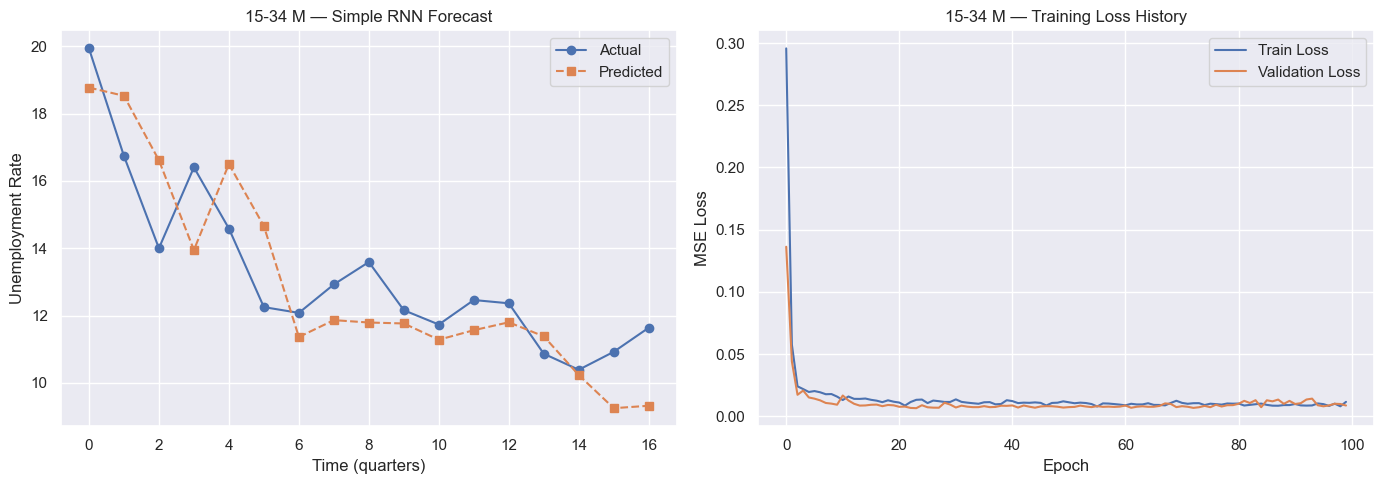


=== Training on column: 15-34 F ===
MAE=1.401  MSE=3.865  RMSE=1.966  MAPE=8.71%
    IC95% MAE : [0.876, 2.143]
    IC95% MSE : [0.933, 8.805]
    IC95% RMSE: [0.966, 2.967]
    IC95% MAPE: [5.68, 12.72]


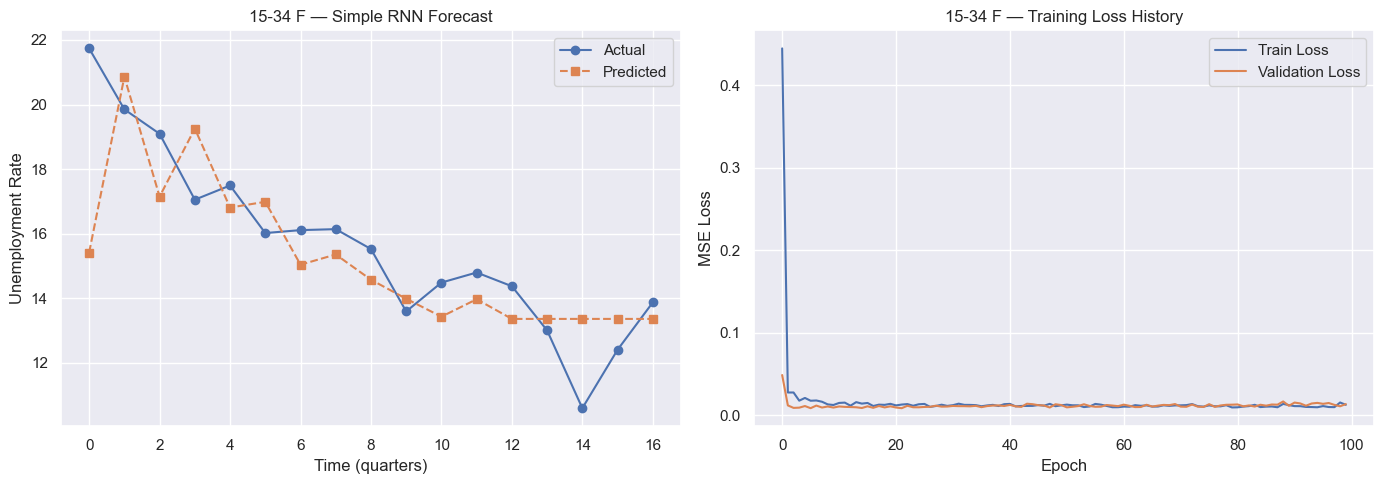


=== Training on column: 35-49 M ===
MAE=0.976  MSE=1.116  RMSE=1.056  MAPE=18.40%
    IC95% MAE : [0.780, 1.177]
    IC95% MSE : [0.715, 1.535]
    IC95% RMSE: [0.846, 1.239]
    IC95% MAPE: [13.87, 23.37]


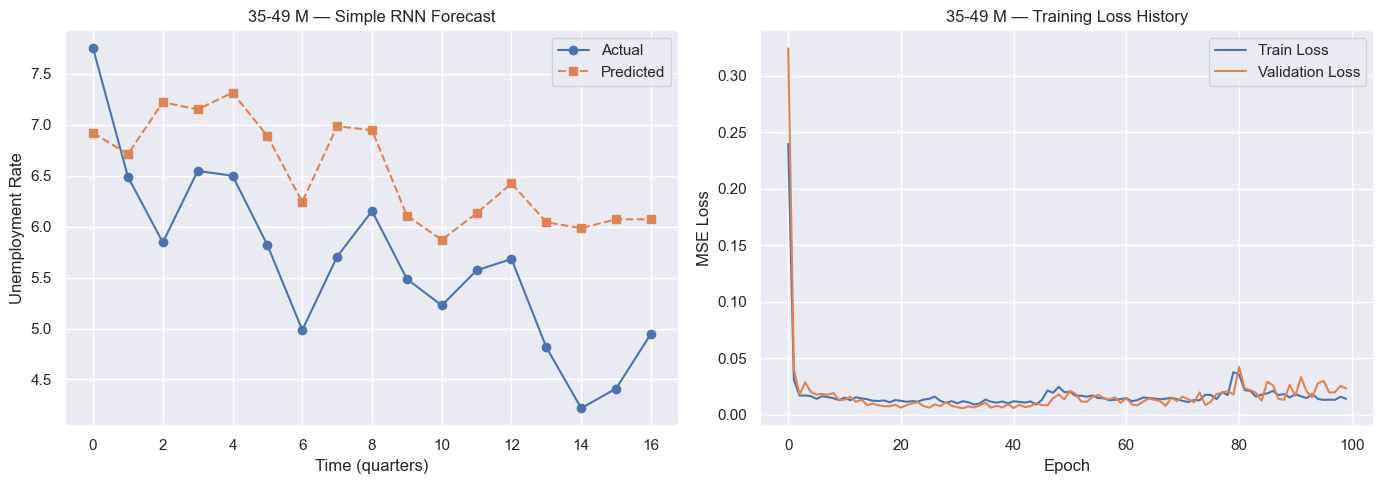


=== Training on column: 35-49 F ===
MAE=1.236  MSE=2.229  RMSE=1.493  MAPE=15.86%
    IC95% MAE : [0.868, 1.643]
    IC95% MSE : [1.126, 3.691]
    IC95% RMSE: [1.061, 1.921]
    IC95% MAPE: [10.44, 22.66]


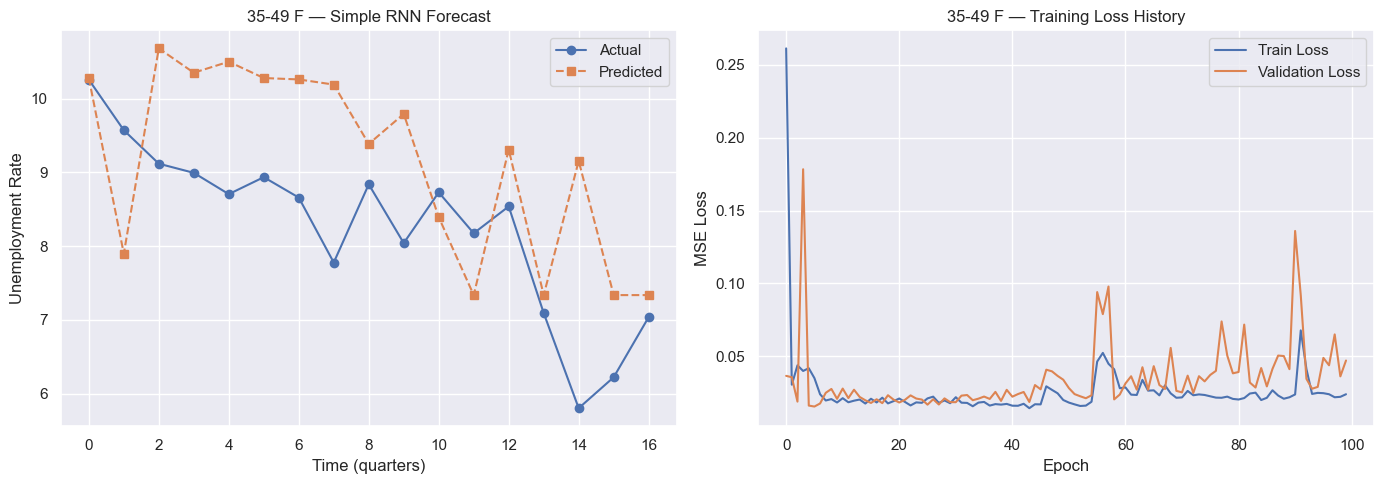


=== Training on column: 50-74 M ===
MAE=1.112  MSE=1.441  RMSE=1.201  MAPE=24.86%
    IC95% MAE : [0.882, 1.314]
    IC95% MSE : [0.991, 1.857]
    IC95% RMSE: [0.995, 1.363]
    IC95% MAPE: [19.33, 29.64]


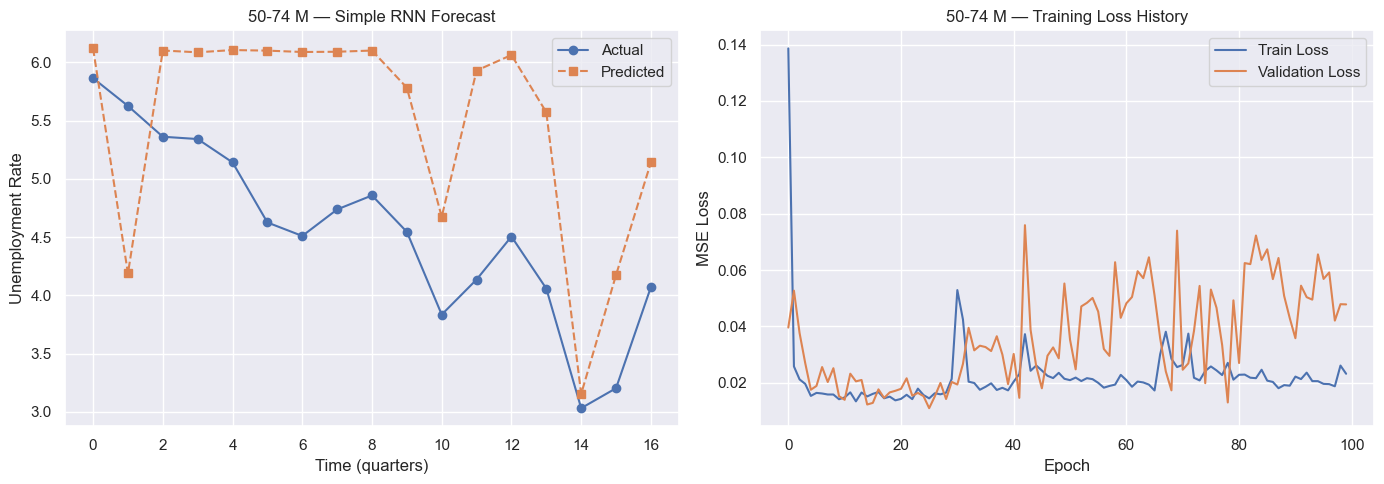


=== Training on column: 50-74 F ===
MAE=0.618  MSE=0.663  RMSE=0.814  MAPE=12.08%
    IC95% MAE : [0.385, 0.894]
    IC95% MSE : [0.206, 1.331]
    IC95% RMSE: [0.454, 1.154]
    IC95% MAPE: [7.29, 17.62]


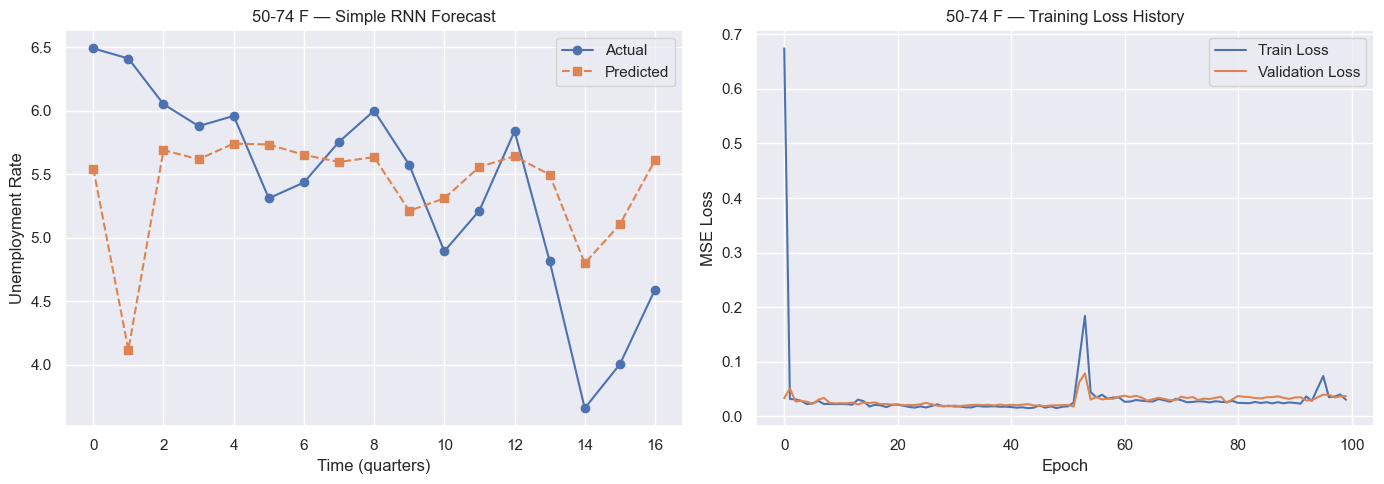


=== Training on column: Global_Rate ===
MAE=1.154  MSE=1.730  RMSE=1.315  MAPE=15.29%
    IC95% MAE : [0.851, 1.448]
    IC95% MSE : [1.029, 2.458]
    IC95% RMSE: [1.015, 1.568]
    IC95% MAPE: [10.95, 20.17]


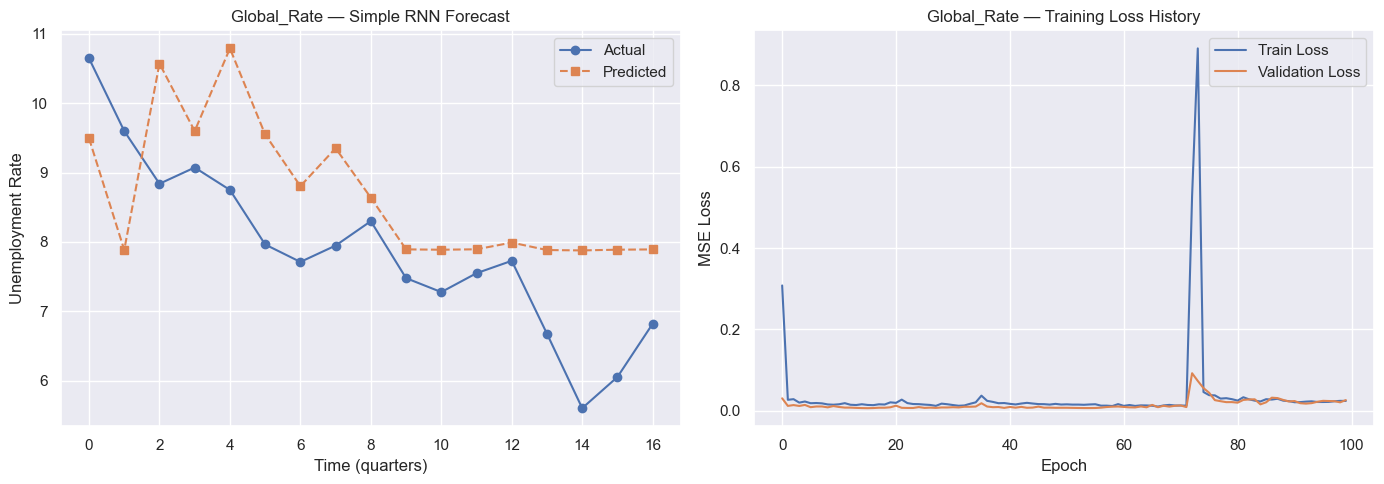

MAE   MAE_low  MAE_high       MSE   MSE_low  MSE_high  \
column                                                                    
15-34 M      1.345882  0.941251  1.700573  2.450564  1.382896  3.561862   
15-34 F      1.401455  0.875777  2.143110  3.864634  0.932728  8.805489   
35-49 M      0.976088  0.780436  1.177101  1.115592  0.715334  1.535132   
35-49 F      1.236393  0.867893  1.642587  2.228606  1.125607  3.691176   
50-74 M      1.112049  0.882180  1.314205  1.441281  0.990964  1.856961   
50-74 F      0.618200  0.385280  0.894082  0.663060  0.206031  1.330895   
Global_Rate  1.154000  0.850543  1.448004  1.730257  1.029324  2.457579   

                 RMSE  RMSE_low  RMSE_high       MAPE   MAPE_low  MAPE_high  
column                                                                       
15-34 M      1.565428  1.175966   1.887290  10.033143   7.191620  12.892331  
15-34 F      1.965867  0.965778   2.967404   8.705157   5.678374  12.721940  
35-49 M      1.056216  0.845774   1.239004  18.404256  13.866483  23.373430  
35-49 F      1.492852  1.060947   1.921243  15.855463  10.442307  22.655725  
50-74 M      1.200534  0.995471   1.362703  24.861062  19.334722  29.639118  
50-74 F      0.814285  0.453906   1.153644  12.079822   7.286883  17.615296  
Global_Rate  1.315392  1.014556   1.567667  15.291734  10.945075  20.165387

          15-34 M    15-34 F   35-49 M   35-49 F   50-74 M   50-74 F  \
2025-Q2  9.323184  13.356834  6.071088  7.335522  5.141215  5.607881   
2025-Q3  7.821067  13.383605  5.512560  7.335522  4.192127  4.775599   
2025-Q4  3.876089  13.387099  4.187799  7.175525  3.149741  3.869734   
2026-Q1  2.559123  13.356834  4.683637  7.335522  3.149945  3.940970   

         Global_Rate  
2025-Q2     7.892649  
2025-Q3     7.633575  
2025-Q4     6.880294  
2026-Q1     6.890286  


In [377]:
# ---------- Reproducibility ----------
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ---------- NEW: helper para IC por bootstrap ----------
from typing import Callable, Tuple

def bootstrap_ci(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    metric_fn: Callable[[np.ndarray, np.ndarray], float],
    n_boot: int = 1000,
    alpha: float = 0.05,
    seed: int = SEED
) -> Tuple[float, float]:
    """Devuelve (inf, sup) del IC (1-alpha) del metric_fn vía bootstrap."""
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)          # remuestreo con reemplazo
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    lower, upper = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return lower, upper

# ---------- Set seaborn style ----------
sns.set_theme(style="darkgrid")  # <-- Aplica estilo para todos los plots

# ---------- Helper: create input/output sequences ----------
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        y.append(data[i])
    return np.array(X).reshape(-1, window, 1), np.array(y)

# ---------- Parameters ----------
window_size = 4                            # 4 quarters for input sequence
test_ratio  = 0.20                          # 20% test split
epochs      = 100
batch_size  = 4
learning_rt = 0.01
steps_ahead = 4                            # steps to forecast ahead

# ---------- Load dataset ----------
df = disocupati_trimestral
print("Columns to process:", list(df.columns))

# ---------- Storage for results ----------
all_metrics = []
all_forecasts = {}
forecast_quarters = ["2025-Q2", "2025-Q3", "2025-Q4", "2026-Q1"]

# ---------- Loop through columns ----------
for col in df.columns:
    print(f"\n=== Training on column: {col} ===")

    # 1) Extract and scale series
    series = df[col].astype("float32")
    scaler = MinMaxScaler((0, 1))
    scaled = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

    # 2) Create sequences
    X, y = create_sequences(scaled, window_size)
    split_idx = int(len(X) * (1 - test_ratio))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # 3) Build model
    model = Sequential([
        SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.3),
        SimpleRNN(50, activation='tanh', return_sequences=False),  
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Nadam(learning_rate=learning_rt), loss="mse")

    # 4) Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )

    # 5) Predict and inverse scale (test predictions)
    y_pred = model.predict(X_test, verbose=0)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # 6) Calculate metrics
    mae  = mean_absolute_error(y_test_inv, y_pred_inv)
    mse  = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

    # ---------- NEW: intervalos de confianza ----------
    mae_ci  = bootstrap_ci(y_test_inv, y_pred_inv, mean_absolute_error)
    mse_ci  = bootstrap_ci(y_test_inv, y_pred_inv, mean_squared_error)
    rmse_ci = bootstrap_ci(y_test_inv, y_pred_inv,
                           lambda a, b: np.sqrt(mean_squared_error(a, b)))
    mape_ci = bootstrap_ci(
        y_test_inv, y_pred_inv,
        lambda a, b: np.mean(np.abs((a - b) / a)) * 100
    )

    print(f"MAE={mae:.3f}  MSE={mse:.3f}  RMSE={rmse:.3f}  MAPE={mape:.2f}%")
    print(f"    IC95% MAE : [{mae_ci[0]:.3f}, {mae_ci[1]:.3f}]")
    print(f"    IC95% MSE : [{mse_ci[0]:.3f}, {mse_ci[1]:.3f}]")
    print(f"    IC95% RMSE: [{rmse_ci[0]:.3f}, {rmse_ci[1]:.3f}]")
    print(f"    IC95% MAPE: [{mape_ci[0]:.2f}, {mape_ci[1]:.2f}]")

    all_metrics.append({
        "column": col,
        "MAE": mae,  "MAE_low": mae_ci[0],  "MAE_high": mae_ci[1],
        "MSE": mse,  "MSE_low": mse_ci[0],  "MSE_high": mse_ci[1],
        "RMSE": rmse,"RMSE_low": rmse_ci[0],"RMSE_high": rmse_ci[1],
        "MAPE": mape,"MAPE_low": mape_ci[0],"MAPE_high": mape_ci[1]
    })
    
    # 7) Multi-step ahead forecast (4 steps)
    last_window = X_test[-1].flatten()
    multi_step_preds = []
    input_seq = last_window.copy()
    for _ in range(steps_ahead):
        input_reshaped = input_seq.reshape(1, window_size, 1)
        next_pred = model.predict(input_reshaped, verbose=0)[0, 0]
        multi_step_preds.append(next_pred)
        input_seq = np.roll(input_seq, -1)
        input_seq[-1] = next_pred
    multi_step_preds_inv = scaler.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))

    # Save forecasts in dict to concatenate later
    all_forecasts[col] = multi_step_preds_inv.flatten()

    # 8) Plot both graphs in a single figure with 2 subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Forecast plot (left)
    axs[0].plot(y_test_inv, label="Actual", marker="o")
    axs[0].plot(y_pred_inv, label="Predicted", marker="s", linestyle="--")
    axs[0].set_title(f"{col} — Simple RNN Forecast")
    axs[0].set_xlabel("Time (quarters)")
    axs[0].set_ylabel("Unemployment Rate")
    axs[0].legend()
    axs[0].grid(True)

    # Training loss plot (right)
    axs[1].plot(history.history["loss"], label="Train Loss")
    axs[1].plot(history.history["val_loss"], label="Validation Loss")
    axs[1].set_title(f"{col} — Training Loss History")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("MSE Loss")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# ---------- Summary table ----------
metrics_df = pd.DataFrame(all_metrics).set_index("column")
display(metrics_df)
metrics_df.to_excel("unemployment_forecast_metrics.xlsx")

# ---------- Create DataFrame for all forecasts ----------
forecast_all_df = pd.DataFrame(all_forecasts, index=forecast_quarters)
print(forecast_all_df)




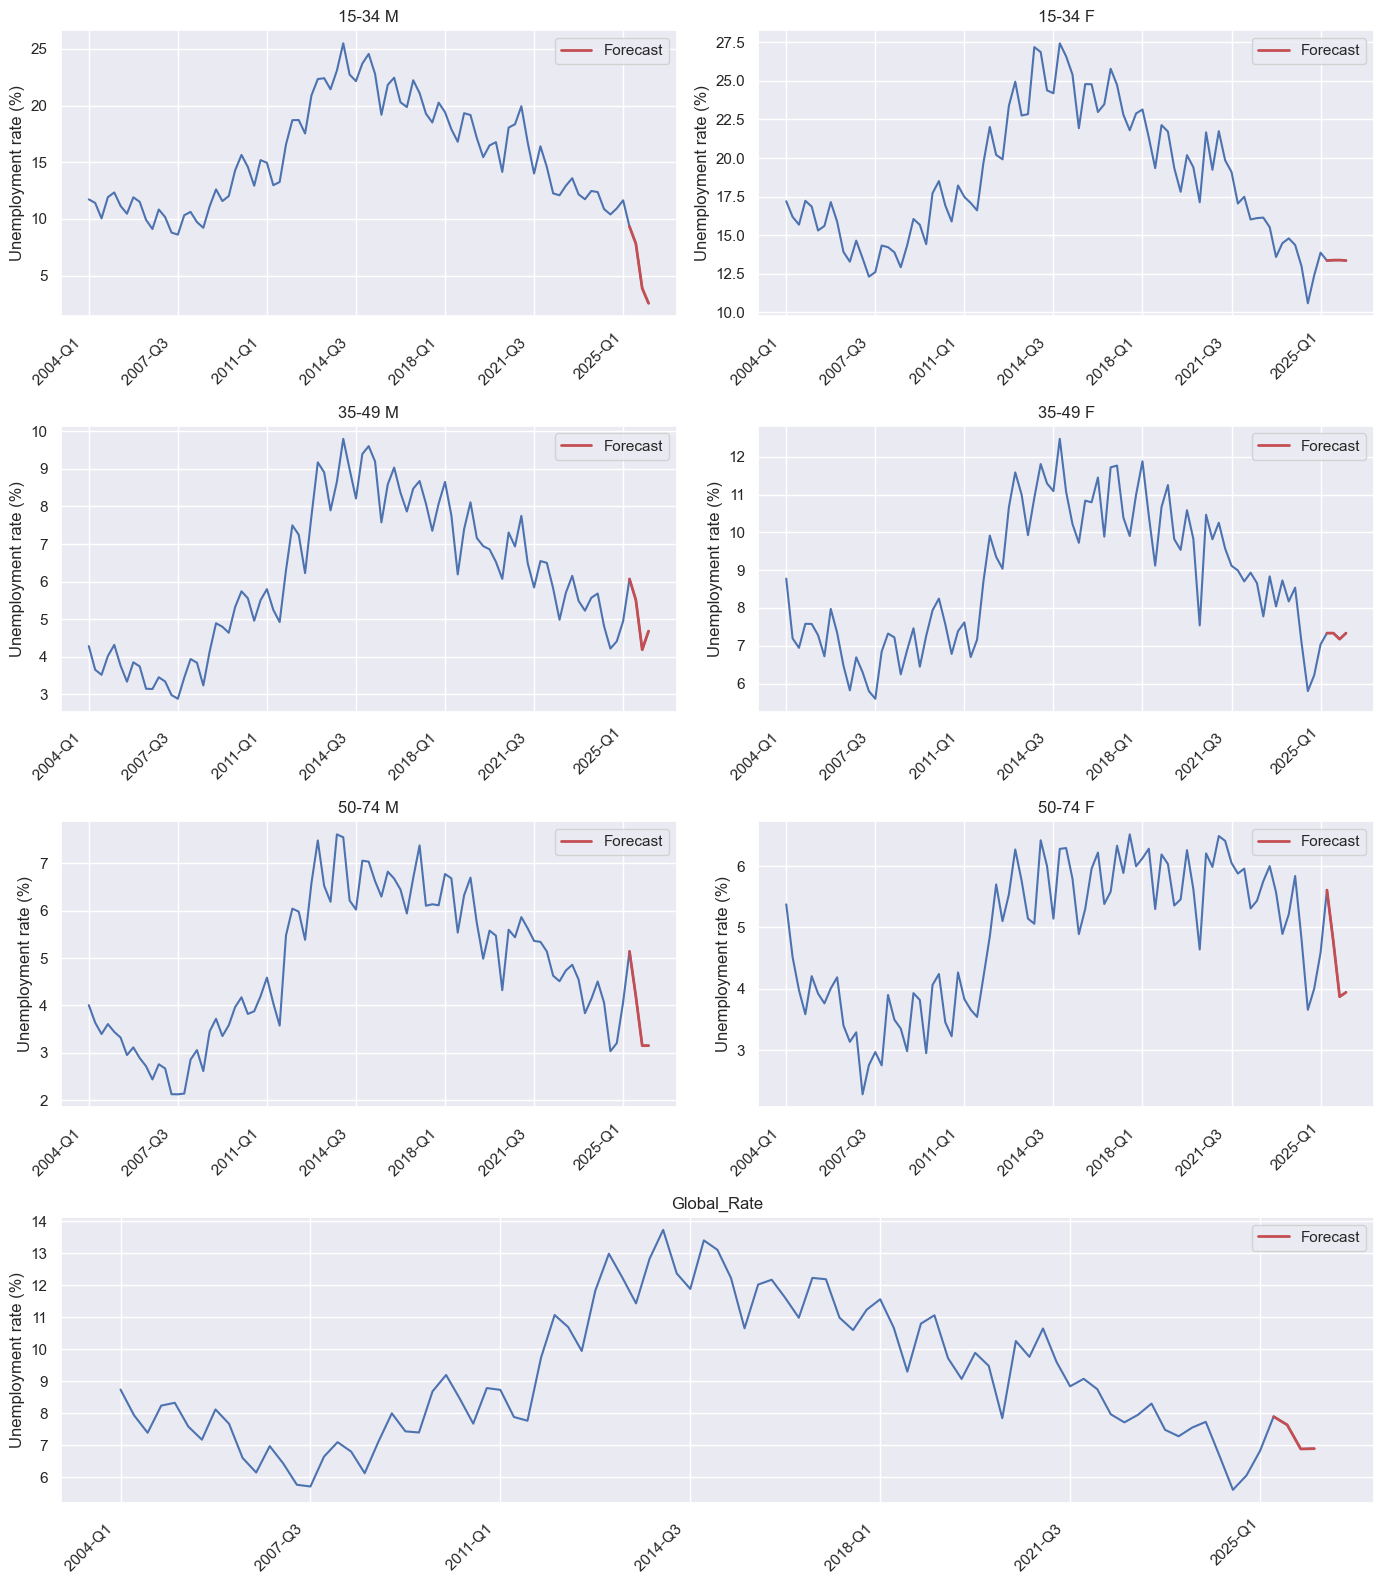

In [378]:
# ---------- Extend original DataFrame with forecasts ----------
# Copy the original historical data
disocupati_extended = disocupati_trimestral.copy()

# Create a forecast DataFrame using the same index and column names
forecast_df = pd.DataFrame(forecast_all_df.values, 
                           columns=forecast_all_df.columns, 
                           index=forecast_quarters)

# Concatenate historical data with forecasts
disocupati_extended = pd.concat([disocupati_extended, forecast_df])

# ---------- Plot the series with forecast highlighted ----------
import matplotlib.pyplot as plt
import numpy as np

quarters_labels = disocupati_extended.index.to_list()
series_names = disocupati_extended.columns.to_list()
n_series = len(series_names)

window_size = len(disocupati_trimestral)  # original historical length
forecast_steps = 4  # number of forecasted quarters

n_rows = (n_series // 2) + (n_series % 2)

fig = plt.figure(figsize=(14, 4 * n_rows))

for i, series_name in enumerate(series_names):
    if (i == n_series - 1) and (n_series % 2 == 1):
        ax = plt.subplot2grid((n_rows, 2), (n_rows-1, 0), colspan=2)
    else:
        ax = plt.subplot(n_rows, 2, i+1)

    series_data = disocupati_extended[series_name]

    # X-axis values
    x = np.arange(len(series_data))

    # Plot the full series
    ax.plot(x, series_data.values)

    # Highlight last 4 forecasted points in red
    ax.plot(x[-forecast_steps:], series_data.values[-forecast_steps:], 'r-', linewidth=2, label='Forecast')

    # Set uniformly spaced x-tick labels
    step_label = max(1, len(x) // 6)
    ax.set_xticks(x[::step_label])
    ax.set_xticklabels([quarters_labels[j] for j in range(0, len(x), step_label)], 
                       rotation=45, ha='right')

    ax.set_title(series_name)
    ax.set_ylabel('Unemployment rate (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

LSTM

Columns to process: ['15-34 M', '15-34 F', '35-49 M', '35-49 F', '50-74 M', '50-74 F', 'Global_Rate']

=== Training on column: 15-34 M ===
MAE=1.166  MSE=2.373  RMSE=1.541  MAPE=8.79%
    IC95% MAE : [0.734, 1.709]
    IC95% MSE : [0.805, 4.687]
    IC95% RMSE: [0.897, 2.165]
    IC95% MAPE: [5.62, 12.73]


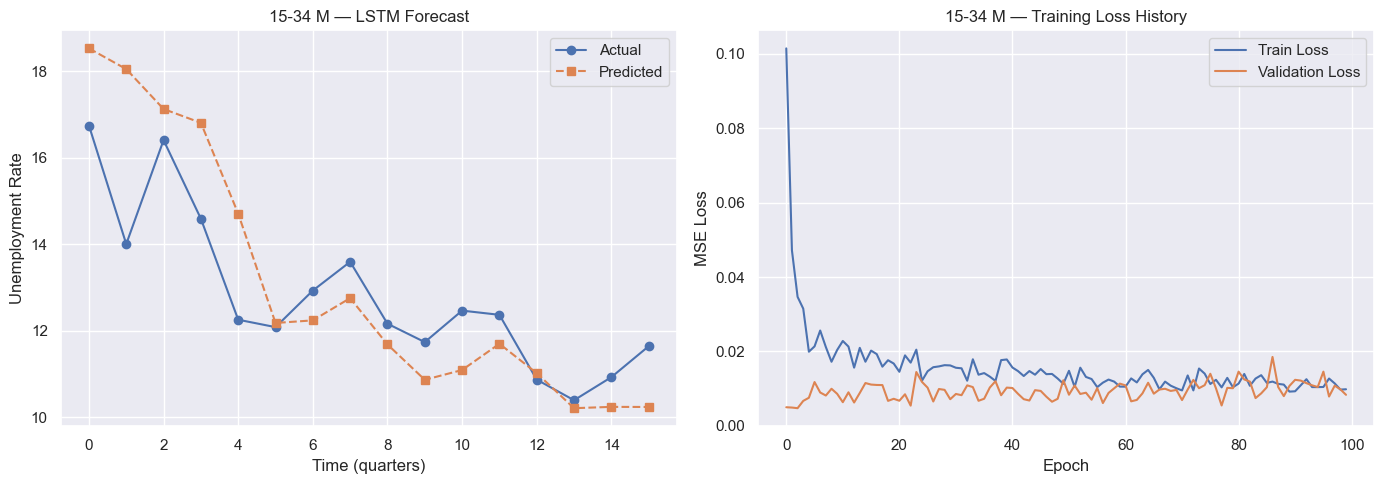


=== Training on column: 15-34 F ===
MAE=1.335  MSE=3.130  RMSE=1.769  MAPE=9.25%
    IC95% MAE : [0.796, 1.921]
    IC95% MSE : [1.104, 5.776]
    IC95% RMSE: [1.051, 2.403]
    IC95% MAPE: [5.22, 13.98]


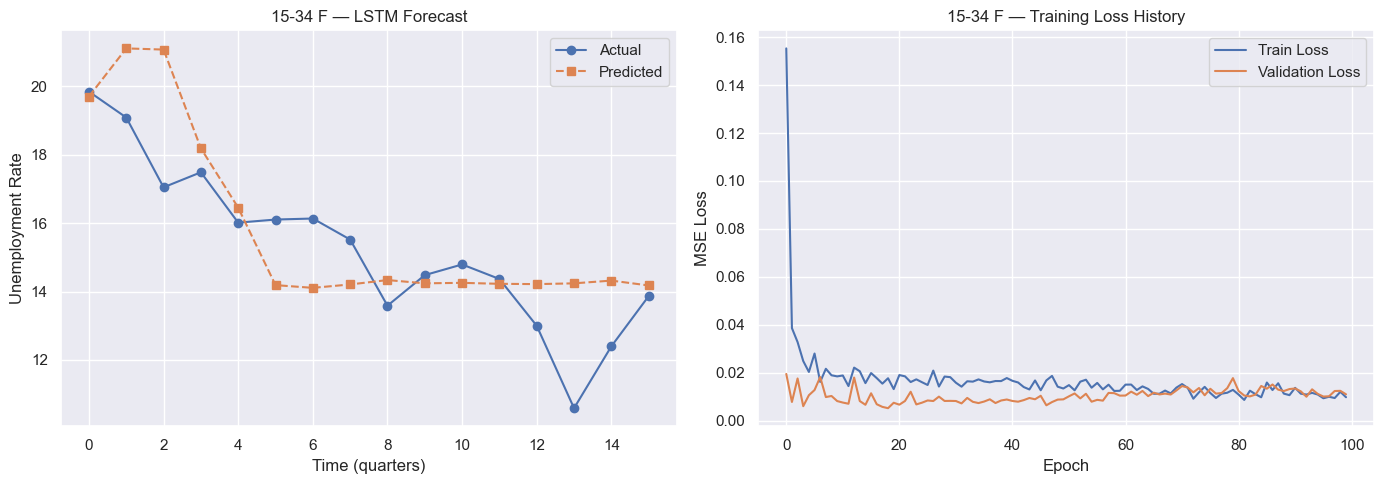


=== Training on column: 35-49 M ===
MAE=0.322  MSE=0.154  RMSE=0.392  MAPE=5.89%
    IC95% MAE : [0.216, 0.424]
    IC95% MSE : [0.074, 0.234]
    IC95% RMSE: [0.271, 0.484]
    IC95% MAPE: [3.89, 7.83]


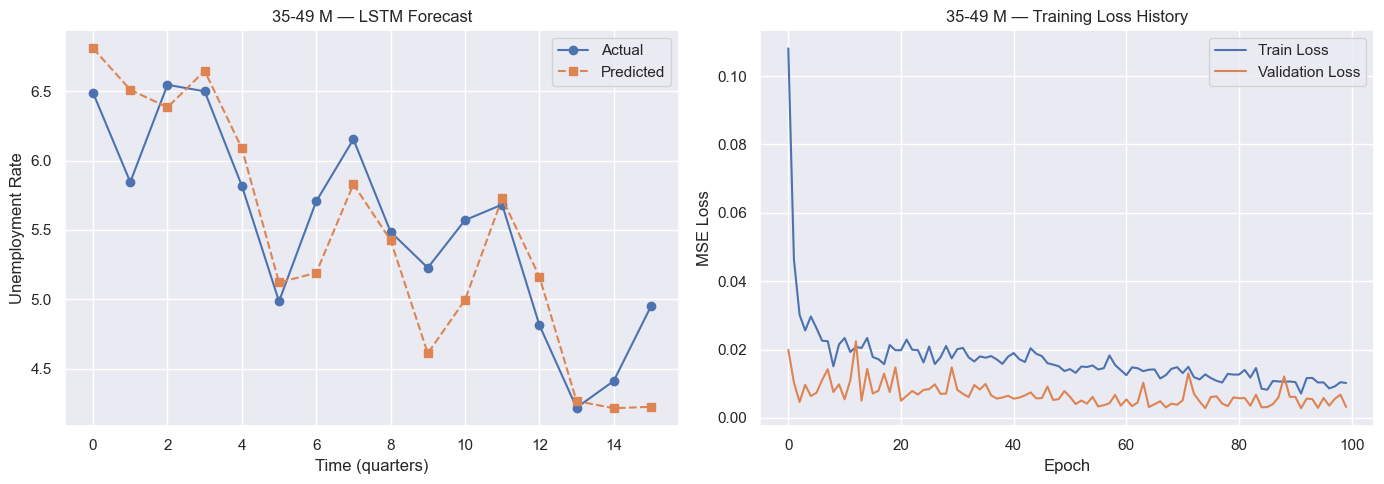


=== Training on column: 35-49 F ===
MAE=0.693  MSE=0.619  RMSE=0.787  MAPE=8.92%
    IC95% MAE : [0.519, 0.878]
    IC95% MSE : [0.366, 0.928]
    IC95% RMSE: [0.605, 0.963]
    IC95% MAPE: [6.31, 12.04]


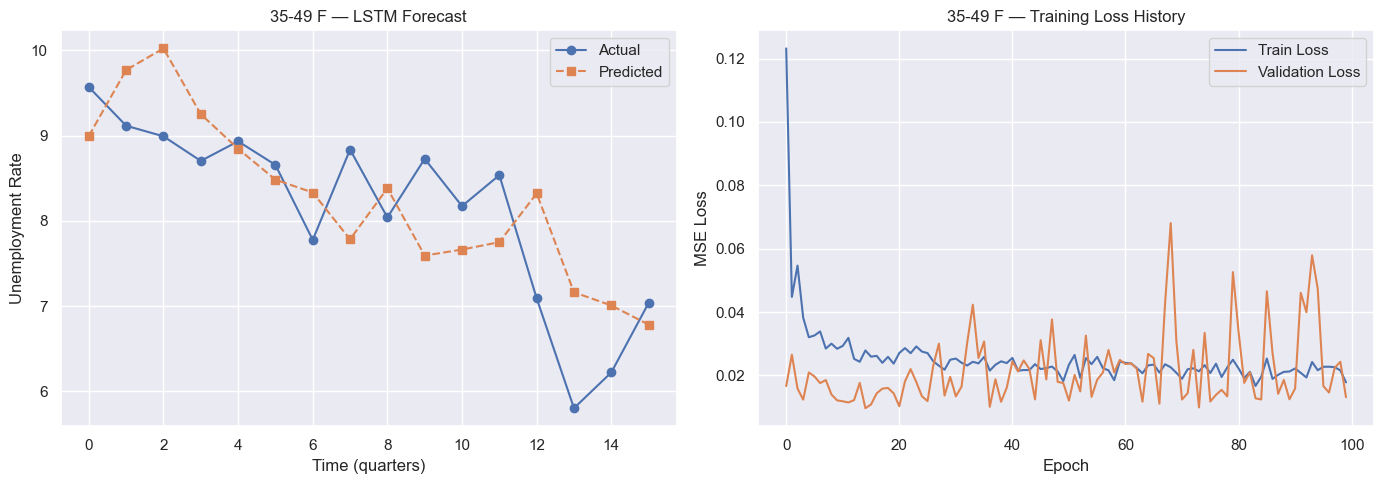


=== Training on column: 50-74 M ===
MAE=0.340  MSE=0.176  RMSE=0.419  MAPE=8.35%
    IC95% MAE : [0.223, 0.477]
    IC95% MSE : [0.078, 0.305]
    IC95% RMSE: [0.279, 0.552]
    IC95% MAPE: [4.94, 12.60]


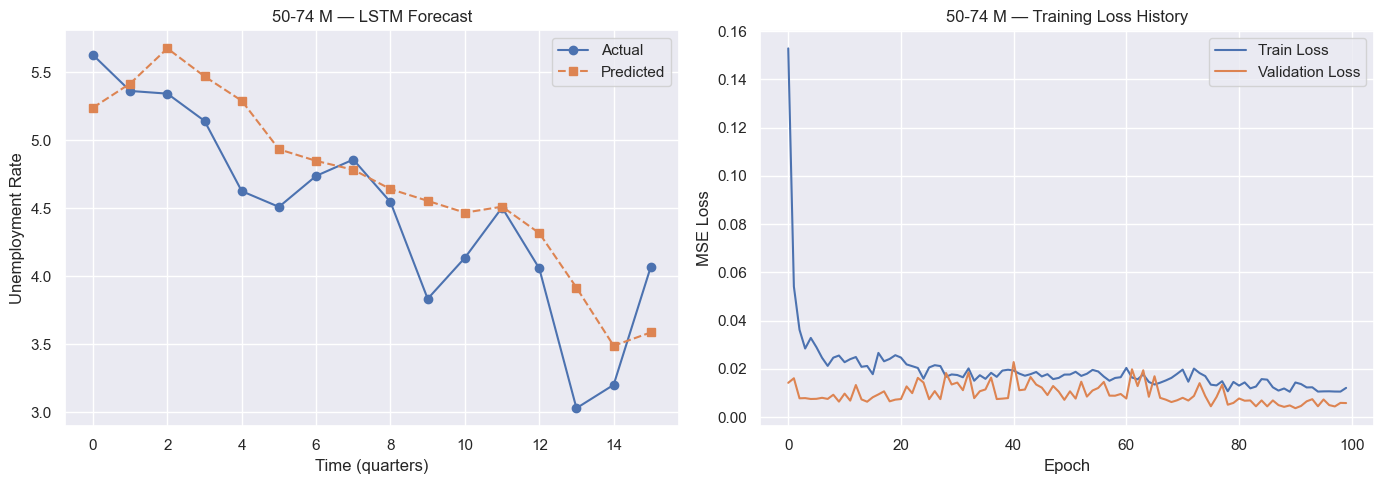


=== Training on column: 50-74 F ===
MAE=0.516  MSE=0.484  RMSE=0.696  MAPE=11.07%
    IC95% MAE : [0.311, 0.777]
    IC95% MSE : [0.145, 1.036]
    IC95% RMSE: [0.380, 1.018]
    IC95% MAPE: [5.85, 18.49]


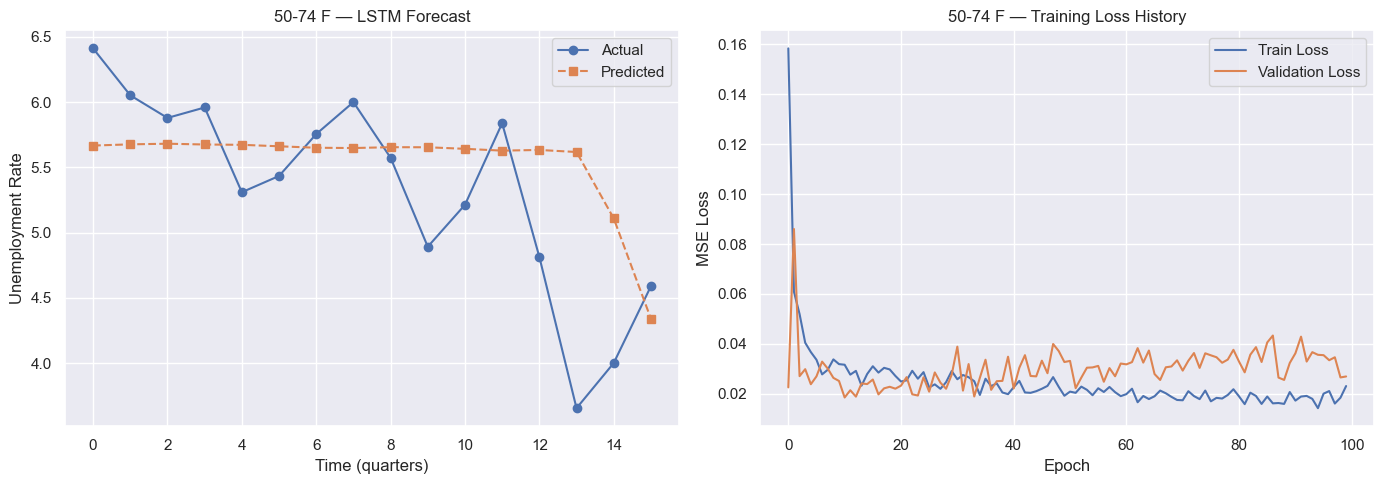


=== Training on column: Global_Rate ===
MAE=0.485  MSE=0.389  RMSE=0.624  MAPE=6.49%
    IC95% MAE : [0.296, 0.687]
    IC95% MSE : [0.160, 0.655]
    IC95% RMSE: [0.400, 0.810]
    IC95% MAPE: [3.75, 9.48]


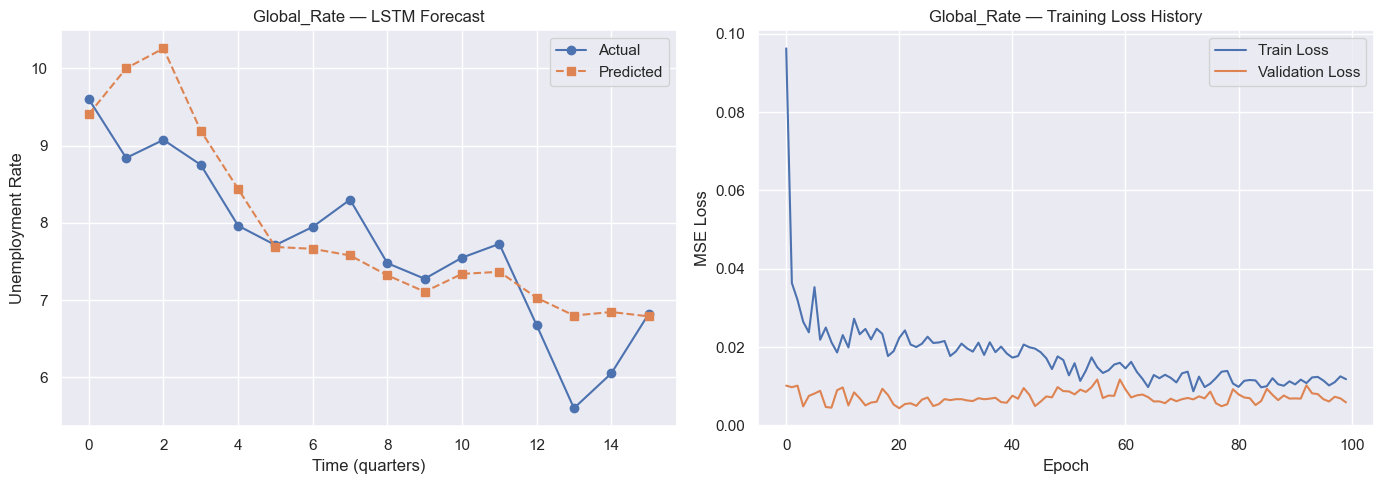

MAE   MAE_low  MAE_high       MSE   MSE_low  MSE_high  \
column                                                                    
15-34 M      1.165861  0.734445  1.709184  2.373470  0.804938  4.687035   
15-34 F      1.335325  0.795712  1.920925  3.130158  1.103573  5.776078   
35-49 M      0.322301  0.215791  0.423751  0.153839  0.073649  0.234005   
35-49 F      0.692593  0.519390  0.877891  0.619187  0.365819  0.927660   
50-74 M      0.340160  0.223478  0.476630  0.175789  0.077930  0.305124   
50-74 F      0.516428  0.310553  0.777383  0.484408  0.144709  1.036081   
Global_Rate  0.484812  0.295639  0.686976  0.389184  0.160134  0.655416   

                 RMSE  RMSE_low  RMSE_high       MAPE  MAPE_low  MAPE_high  
column                                                                      
15-34 M      1.540607  0.897183   2.164956   8.793598  5.615639  12.726964  
15-34 F      1.769225  1.050511   2.403347   9.250706  5.216355  13.982796  
35-49 M      0.392223  0.271383   0.483740   5.890033  3.887870   7.827936  
35-49 F      0.786884  0.604829   0.963151   8.920231  6.308788  12.037252  
50-74 M      0.419272  0.279159   0.552381   8.348772  4.937849  12.603448  
50-74 F      0.695994  0.380407   1.017880  11.073804  5.852059  18.488117  
Global_Rate  0.623846  0.400168   0.809577   6.493998  3.754763   9.477426

15-34 M    15-34 F   35-49 M   35-49 F   50-74 M   50-74 F  \
2025-Q2  10.236290  14.180142  4.224590  6.783056  3.587933  4.341605   
2025-Q3  10.047126  14.119835  3.783515  6.524980  3.191678  3.909167   
2025-Q4   9.975223  14.128835  3.487983  6.082161  2.916936  3.623404   
2026-Q1  10.048584  14.196730  3.482001  6.503311  2.937104  3.614021   

         Global_Rate  
2025-Q2     6.790595  
2025-Q3     6.728154  
2025-Q4     6.734190  
2026-Q1     6.890625

In [379]:
# ---------- Reproducibility ----------
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ---------- helper para IC por bootstrap ----------
from typing import Callable, Tuple

def bootstrap_ci(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    metric_fn: Callable[[np.ndarray, np.ndarray], float],
    n_boot: int = 1000,
    alpha: float = 0.05,
    seed: int = SEED
) -> Tuple[float, float]:
    """Devuelve (inf, sup) del IC (1-alpha) del metric_fn vía bootstrap."""
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)          # remuestreo con reemplazo
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    lower, upper = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return lower, upper

# ---------- Set seaborn style ----------
sns.set_theme(style="darkgrid")  

# ---------- Helper: create input/output sequences ----------
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        y.append(data[i])
    return np.array(X).reshape(-1, window, 1), np.array(y)

# ---------- Parameters ----------
window_size = 6                             # 4 quarters for input sequence
test_ratio  = 0.20                          # 20% test split
epochs      = 100
batch_size  = 4
learning_rt = 0.01
steps_ahead = 4                            # steps to forecast ahead

# ---------- Load dataset ----------
df = disocupati_trimestral
print("Columns to process:", list(df.columns))

# ---------- Storage for results ----------
all_metrics = []
all_forecasts = {}
forecast_quarters = ["2025-Q2", "2025-Q3", "2025-Q4", "2026-Q1"]

# ---------- Loop through columns ----------
for col in df.columns:
    print(f"\n=== Training on column: {col} ===")

    # 1) Extract and scale series
    series = df[col].astype("float32")
    scaler = MinMaxScaler((0, 1))
    scaled = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

    # 2) Create sequences
    X, y = create_sequences(scaled, window_size)
    split_idx = int(len(X) * (1 - test_ratio))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # 3) Build model
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.5),
        LSTM(64, activation='tanh', return_sequences=False),  
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Nadam(learning_rate=learning_rt), loss="mse")

    # 4) Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )

    # 5) Predict and inverse scale (test predictions)
    y_pred = model.predict(X_test, verbose=0)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # 6) Calculate metrics
    mae  = mean_absolute_error(y_test_inv, y_pred_inv)
    mse  = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

    mae_ci  = bootstrap_ci(y_test_inv, y_pred_inv, mean_absolute_error)
    mse_ci  = bootstrap_ci(y_test_inv, y_pred_inv, mean_squared_error)
    rmse_ci = bootstrap_ci(y_test_inv, y_pred_inv,
                           lambda a, b: np.sqrt(mean_squared_error(a, b)))
    mape_ci = bootstrap_ci(
        y_test_inv, y_pred_inv,
        lambda a, b: np.mean(np.abs((a - b) / a)) * 100
    )

    print(f"MAE={mae:.3f}  MSE={mse:.3f}  RMSE={rmse:.3f}  MAPE={mape:.2f}%")
    print(f"    IC95% MAE : [{mae_ci[0]:.3f}, {mae_ci[1]:.3f}]")
    print(f"    IC95% MSE : [{mse_ci[0]:.3f}, {mse_ci[1]:.3f}]")
    print(f"    IC95% RMSE: [{rmse_ci[0]:.3f}, {rmse_ci[1]:.3f}]")
    print(f"    IC95% MAPE: [{mape_ci[0]:.2f}, {mape_ci[1]:.2f}]")

    all_metrics.append({
        "column": col,
        "MAE": mae,  "MAE_low": mae_ci[0],  "MAE_high": mae_ci[1],
        "MSE": mse,  "MSE_low": mse_ci[0],  "MSE_high": mse_ci[1],
        "RMSE": rmse,"RMSE_low": rmse_ci[0],"RMSE_high": rmse_ci[1],
        "MAPE": mape,"MAPE_low": mape_ci[0],"MAPE_high": mape_ci[1]
    })
    
    # 7) Multi-step ahead forecast (4 steps)
    last_window = X_test[-1].flatten()
    multi_step_preds = []
    input_seq = last_window.copy()
    for _ in range(steps_ahead):
        input_reshaped = input_seq.reshape(1, window_size, 1)
        next_pred = model.predict(input_reshaped, verbose=0)[0, 0]
        multi_step_preds.append(next_pred)
        input_seq = np.roll(input_seq, -1)
        input_seq[-1] = next_pred
    multi_step_preds_inv = scaler.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))

    # Save forecasts in dict to concatenate later
    all_forecasts[col] = multi_step_preds_inv.flatten()

    # 8) Plot both graphs in a single figure with 2 subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Forecast plot (left)
    axs[0].plot(y_test_inv, label="Actual", marker="o")
    axs[0].plot(y_pred_inv, label="Predicted", marker="s", linestyle="--")
    axs[0].set_title(f"{col} — LSTM Forecast")
    axs[0].set_xlabel("Time (quarters)")
    axs[0].set_ylabel("Unemployment Rate")
    axs[0].legend()
    axs[0].grid(True)

    # Training loss plot (right)
    axs[1].plot(history.history["loss"], label="Train Loss")
    axs[1].plot(history.history["val_loss"], label="Validation Loss")
    axs[1].set_title(f"{col} — Training Loss History")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("MSE Loss")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# ---------- Summary table ----------
metrics_df = pd.DataFrame(all_metrics).set_index("column")
display(metrics_df)
metrics_df.to_excel("unemployment_forecast_metricsLSTM.xlsx")

# ---------- Create DataFrame for all forecasts ----------
forecast_all_df = pd.DataFrame(all_forecasts, index=forecast_quarters)
display(forecast_all_df)
forecast_all_df.to_excel("unemployment_forecast_LSTM.xlsx")


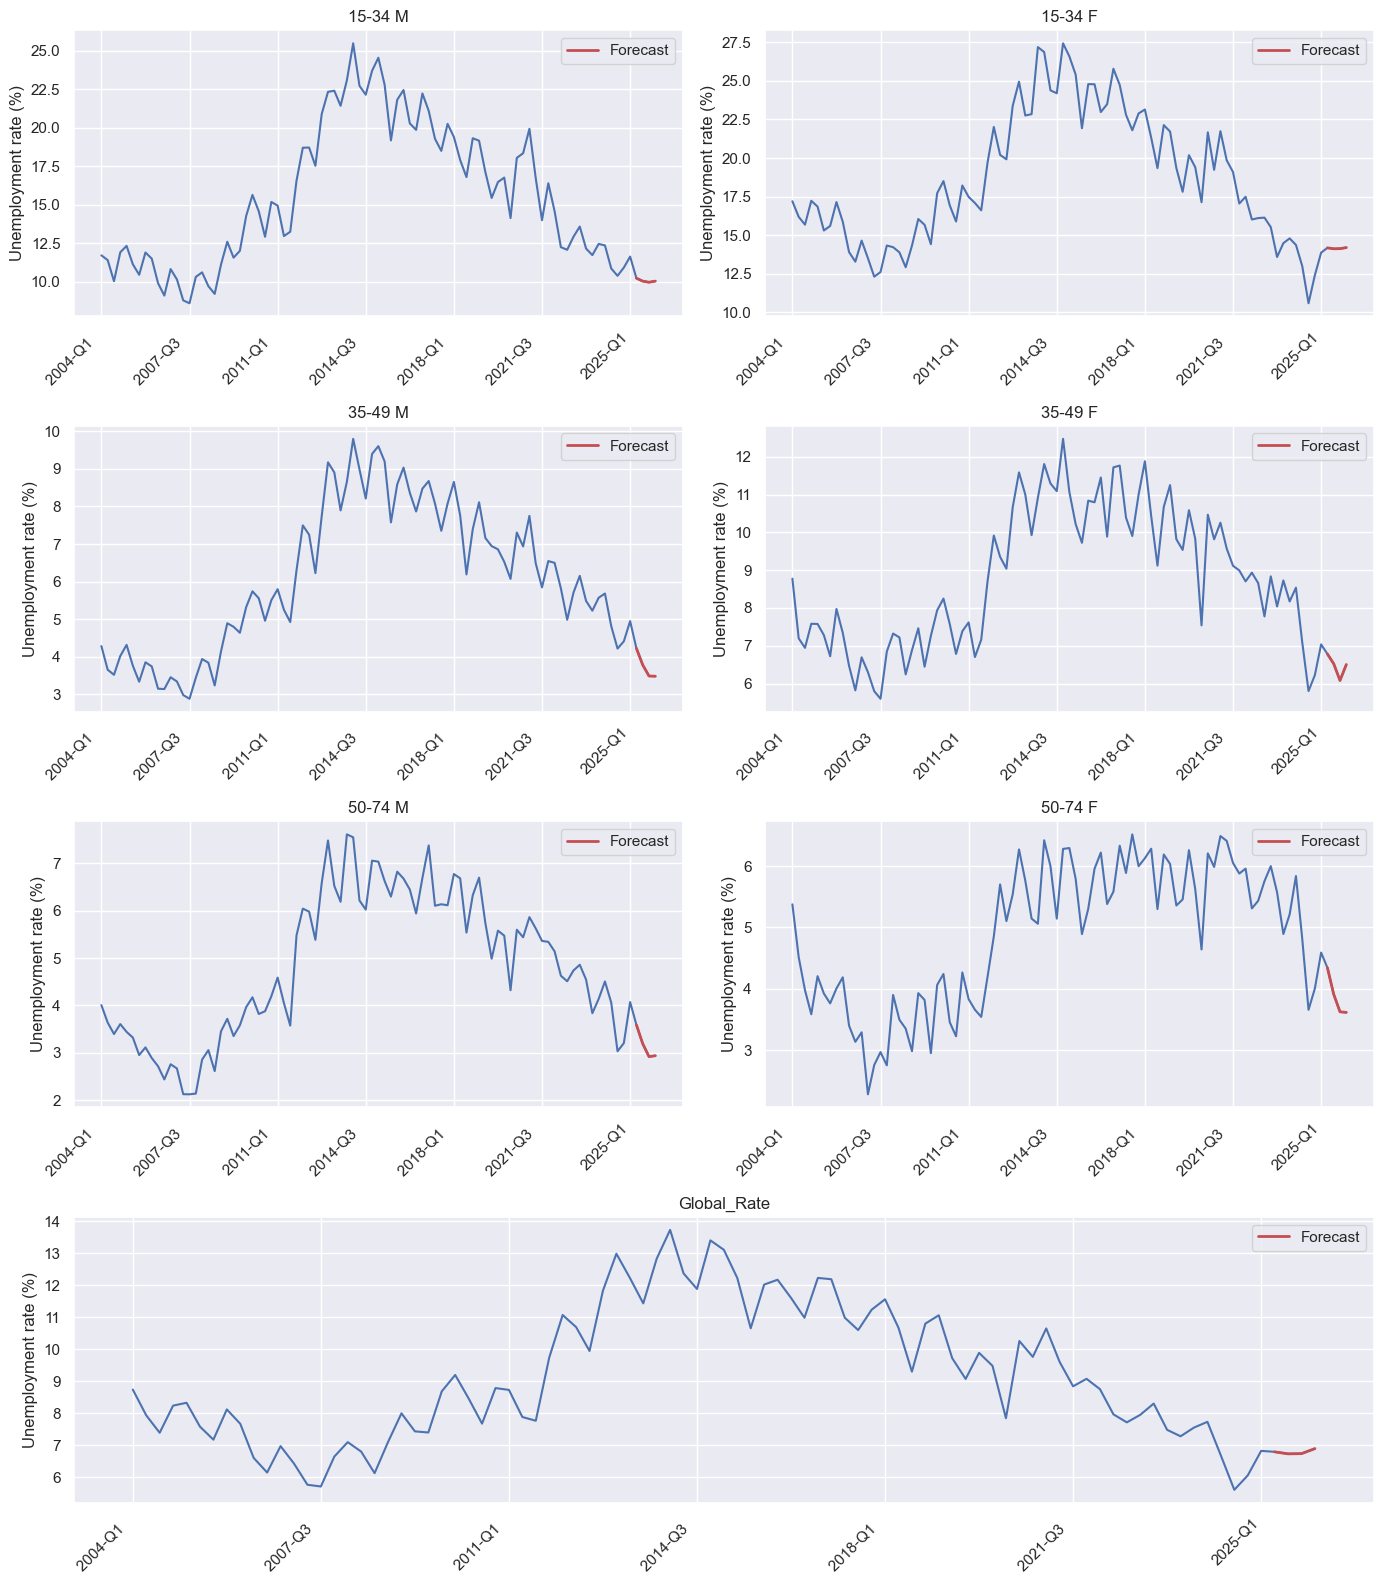

In [380]:
# ---------- Extend original DataFrame with forecasts ----------
# Copy the original historical data
disocupati_extended = disocupati_trimestral.copy()

# Create a forecast DataFrame using the same index and column names
forecast_df = pd.DataFrame(forecast_all_df.values, 
                           columns=forecast_all_df.columns, 
                           index=forecast_quarters)

# Concatenate historical data with forecasts
disocupati_extended = pd.concat([disocupati_extended, forecast_df])

# ---------- Plot the series with forecast highlighted ----------
import matplotlib.pyplot as plt
import numpy as np

quarters_labels = disocupati_extended.index.to_list()
series_names = disocupati_extended.columns.to_list()
n_series = len(series_names)

window_size = len(disocupati_trimestral)  # original historical length
forecast_steps = 4  # number of forecasted quarters

n_rows = (n_series // 2) + (n_series % 2)

fig = plt.figure(figsize=(14, 4 * n_rows))

for i, series_name in enumerate(series_names):
    if (i == n_series - 1) and (n_series % 2 == 1):
        ax = plt.subplot2grid((n_rows, 2), (n_rows-1, 0), colspan=2)
    else:
        ax = plt.subplot(n_rows, 2, i+1)

    series_data = disocupati_extended[series_name]

    # X-axis values
    x = np.arange(len(series_data))

    # Plot the full series
    ax.plot(x, series_data.values)

    # Highlight last 4 forecasted points in red
    ax.plot(x[-forecast_steps:], series_data.values[-forecast_steps:], 'r-', linewidth=2, label='Forecast')

    # Set uniformly spaced x-tick labels
    step_label = max(1, len(x) // 6)
    ax.set_xticks(x[::step_label])
    ax.set_xticklabels([quarters_labels[j] for j in range(0, len(x), step_label)], 
                       rotation=45, ha='right')

    ax.set_title(series_name)
    ax.set_ylabel('Unemployment rate (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()